In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import librosa
from tqdm import tqdm
from IPython.display import Audio
from pandas.api.types import is_numeric_dtype

import sys
sys.path.append('../')
import default_style

TS_DATASET_FOLDER = os.path.join("..", "dataset")
TS_PREPROC_FOLDER = os.path.join(TS_DATASET_FOLDER, "preprocessed_traces")
DF_PREPROC_FILE = os.path.join(TS_PREPROC_FOLDER, "preproc_ts.df")

INTERESTING_TRACES = ["clean_trace"]


df = pd.read_csv(DF_PREPROC_FILE)
traces = dict()
for t in INTERESTING_TRACES:
    traces[t] = np.load(os.path.join(TS_PREPROC_FOLDER, f"{t}.npy"), allow_pickle=True)

# traces["syll_labels"] = np.repeat(np.arange(7), len(traces["syllables_fourier"])//7)
# print(traces["syll_labels"].shape)

SAMPLING_RATE = 48_000/8

%load_ext autoreload
%autoreload 2

## Define a model

In [2]:
from keras.layers import Conv1D, Dense, Flatten, AveragePooling1D
from keras.models import Sequential

# Use different conv layers
def build_model(input_shape, n_categories,
                
                # Convolution parameters
                conv_filter_sizes = [16, 8],
                conv_kernel_sizes = [5, 3],
                conv_pool_sizes = [2, None],
                conv_padding="valid",
                
                # Dense parameters
                n_dense_layers=2,
                dense_nodes=256,
                **kwargs):
    
    n_conv_blocks = len(conv_filter_sizes)

    model = Sequential()
    
    # Conv1d + temporal average pooling
    for block_id in range(n_conv_blocks):
        conv = Conv1D(conv_filter_sizes[block_id], conv_kernel_sizes[block_id], 
                      input_shape=input_shape,
                      activation="relu", 
                      name=f"conv_{block_id}",
                        padding=conv_padding
                     )
        
        
        model.add(conv)
        if block_id < n_conv_blocks - 1:
            pool = AveragePooling1D(pool_size=conv_pool_sizes[block_id], name=f"avg_pooling_{block_id}")
            model.add(pool)
            
    # Flattens stuff :3
    model.add(Flatten())
    
    # A good dose of Dense layers never hurted anybody
    for block_id in range(n_dense_layers):
        model.add(Dense(dense_nodes, 
                        activation="relu", 
                        name=f"dense_{block_id}"))
    
    # Let the garbage out
    model.add(Dense(n_categories, 
                    activation="softmax",
                    name="output"))
    
    model.compile(optimizer="adam", 
                  loss="sparse_categorical_crossentropy", 
                  metrics=['accuracy'])
    return model

2023-07-04 14:52:52.732945: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-04 14:52:52.810999: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-04 14:52:52.812537: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-04 14:52:54.135210: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Tuning (for prediction of almost all categories)

### Prepare the different resolutions

In [3]:
# In the tuning the spectral resolution is optimized too
from djanloo_fourier import FixedResolutionSTFTransformer
from tensorflow.keras.preprocessing.sequence import pad_sequences

STFT_dict = dict()
possible_resolutions = [90, 100, 110, 115]
for res in possible_resolutions:
    ## Really gets the dataset of STFTs
    fixedtr = FixedResolutionSTFTransformer(n_spectral_points=res,
                                            pad_spectra=False,
                                            verbose=True)
    
    # Gets STFTs
    STFTs = fixedtr.transform(traces["clean_trace"])
    STFT_dict[res] = pad_sequences(STFTs)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2452/2452 [00:11<00:00, 208.54it/s]


In [4]:
from sklearn.preprocessing import LabelEncoder

# Gets labels
enc = LabelEncoder()
labels = np.array([f"{s} {e} {vc}" for s,e,vc in zip(df.sex, df.emotion, df.vocal_channel)])
y = enc.fit_transform(labels)

### Define the objective function to maximise

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

def objective(trial, train_idxs, val_idxs):
    global y, possible_resolutions
    
    epochs=trial.suggest_int('epochs',15,40)
    
    # Gets the data
    X = STFT_dict[trial.suggest_categorical("resolution", choices=possible_resolutions)]
    
    # Builds the convolutional parameters
    n_conv_blocks = trial.suggest_int('n_conv_blocks', 1, 3)
    filter_sizes, kernel_sizes, pool_sizes = [], [], []  
    for block_id in range(n_conv_blocks):
        filter_sizes.append(trial.suggest_int(f'filters_{block_id}', 2, 16))
        kernel_sizes.append(trial.suggest_int(f'kernels_{block_id}', 3, 9))
        pool_sizes.append(trial.suggest_int(f'pool_{block_id}', 2, 8))

    
    ## Concerning the model ...
    pars = dict(## Conv stuff 
                conv_filter_sizes=filter_sizes, 
                conv_kernel_sizes=kernel_sizes, 
                conv_pool_sizes=pool_sizes,
                conv_padding=trial.suggest_categorical("conv_padding", choices=["valid", "causal"]),
        
                ## Dense stuff
                n_dense_layers=trial.suggest_int('n_dense_layers', 1, 3), 
                dense_nodes=trial.suggest_int('dense_nodes', 16, 512)
               )
    print(f"running model having {pars} with SpRes = {fixedtr.n_spectral_points} for epochs = {epochs}")
    
    model = build_model(X.shape[1:], len(np.unique(y)), **pars)
    model.fit(
                    X[train_idxs], y[train_idxs], 
                    epochs=epochs,
                    batch_size=trial.suggest_int('batch_size', 16, 32),
                    verbose=False
                    )
    
    ## Estimate accuracy
    y_pred = np.argmax(model.predict(X[val_idxs], verbose=False), axis=1)
    acc = accuracy_score(y[val_idxs], y_pred)
    
    return acc

In [6]:
## Splits the dataset
idxs = np.arange(len(df))
np.random.shuffle(idxs)
train_idxs, val_idxs, test_idxs = np.split(idxs, (len(df)*np.array([0.7, 0.8])).astype(int))

In [7]:
import optuna
study = optuna.create_study(direction='maximize')
trial_function = lambda trial: objective(trial, train_idxs, val_idxs)
study.optimize(trial_function, n_trials=300, n_jobs=1, catch=ValueError)

[I 2023-07-03 17:12:27,990] A new study created in memory with name: no-name-444a086c-7b97-4f92-84b1-9eb8a5850269


running model having {'conv_filter_sizes': [8], 'conv_kernel_sizes': [3], 'conv_pool_sizes': [8], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 177} with SpRes = 115 for epochs = 37


2023-07-03 17:12:28.541756: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 208391040 exceeds 10% of free system memory.
[I 2023-07-03 17:13:11,320] Trial 0 finished with value: 0.42857142857142855 and parameters: {'epochs': 37, 'resolution': 115, 'n_conv_blocks': 1, 'filters_0': 8, 'kernels_0': 3, 'pool_0': 8, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 177, 'batch_size': 25}. Best is trial 0 with value: 0.42857142857142855.


running model having {'conv_filter_sizes': [2, 7], 'conv_kernel_sizes': [3, 8], 'conv_pool_sizes': [6, 8], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 202} with SpRes = 115 for epochs = 37


2023-07-03 17:13:12.081959: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 208391040 exceeds 10% of free system memory.
[I 2023-07-03 17:13:46,276] Trial 1 finished with value: 0.35918367346938773 and parameters: {'epochs': 37, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 2, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 7, 'kernels_1': 8, 'pool_1': 8, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 202, 'batch_size': 24}. Best is trial 0 with value: 0.42857142857142855.


running model having {'conv_filter_sizes': [12, 13], 'conv_kernel_sizes': [7, 9], 'conv_pool_sizes': [5, 7], 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 241} with SpRes = 115 for epochs = 35


2023-07-03 17:13:46.883655: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 208391040 exceeds 10% of free system memory.
[I 2023-07-03 17:14:41,481] Trial 2 finished with value: 0.4489795918367347 and parameters: {'epochs': 35, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 7, 'pool_0': 5, 'filters_1': 13, 'kernels_1': 9, 'pool_1': 7, 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 241, 'batch_size': 31}. Best is trial 2 with value: 0.4489795918367347.


running model having {'conv_filter_sizes': [11], 'conv_kernel_sizes': [9], 'conv_pool_sizes': [3], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 512} with SpRes = 115 for epochs = 18


2023-07-03 17:14:41.929238: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 208185120 exceeds 10% of free system memory.
[I 2023-07-03 17:15:57,614] Trial 3 finished with value: 0.22040816326530613 and parameters: {'epochs': 18, 'resolution': 90, 'n_conv_blocks': 1, 'filters_0': 11, 'kernels_0': 9, 'pool_0': 3, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 512, 'batch_size': 19}. Best is trial 2 with value: 0.4489795918367347.


running model having {'conv_filter_sizes': [14, 12], 'conv_kernel_sizes': [4, 6], 'conv_pool_sizes': [7, 6], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 216} with SpRes = 115 for epochs = 16


2023-07-03 17:15:58.062289: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 208391040 exceeds 10% of free system memory.
[I 2023-07-03 17:16:20,090] Trial 4 finished with value: 0.4163265306122449 and parameters: {'epochs': 16, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 4, 'pool_0': 7, 'filters_1': 12, 'kernels_1': 6, 'pool_1': 6, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 216, 'batch_size': 16}. Best is trial 2 with value: 0.4489795918367347.


running model having {'conv_filter_sizes': [16, 15, 13], 'conv_kernel_sizes': [3, 8, 5], 'conv_pool_sizes': [5, 7, 4], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 312} with SpRes = 115 for epochs = 27


[I 2023-07-03 17:16:48,618] Trial 5 finished with value: 0.43673469387755104 and parameters: {'epochs': 27, 'resolution': 100, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 3, 'pool_0': 5, 'filters_1': 15, 'kernels_1': 8, 'pool_1': 7, 'filters_2': 13, 'kernels_2': 5, 'pool_2': 4, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 312, 'batch_size': 26}. Best is trial 2 with value: 0.4489795918367347.


running model having {'conv_filter_sizes': [10, 8, 7], 'conv_kernel_sizes': [5, 8, 8], 'conv_pool_sizes': [2, 3, 4], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 56} with SpRes = 115 for epochs = 17


[I 2023-07-03 17:17:13,264] Trial 6 finished with value: 0.40816326530612246 and parameters: {'epochs': 17, 'resolution': 115, 'n_conv_blocks': 3, 'filters_0': 10, 'kernels_0': 5, 'pool_0': 2, 'filters_1': 8, 'kernels_1': 8, 'pool_1': 3, 'filters_2': 7, 'kernels_2': 8, 'pool_2': 4, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 56, 'batch_size': 24}. Best is trial 2 with value: 0.4489795918367347.


running model having {'conv_filter_sizes': [4, 3, 14], 'conv_kernel_sizes': [9, 5, 5], 'conv_pool_sizes': [8, 7, 3], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 310} with SpRes = 115 for epochs = 32


[I 2023-07-03 17:18:13,856] Trial 7 finished with value: 0.40408163265306124 and parameters: {'epochs': 32, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 4, 'kernels_0': 9, 'pool_0': 8, 'filters_1': 3, 'kernels_1': 5, 'pool_1': 7, 'filters_2': 14, 'kernels_2': 5, 'pool_2': 3, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 310, 'batch_size': 25}. Best is trial 2 with value: 0.4489795918367347.


running model having {'conv_filter_sizes': [15, 10, 11], 'conv_kernel_sizes': [7, 9, 6], 'conv_pool_sizes': [6, 3, 5], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 319} with SpRes = 115 for epochs = 29


[I 2023-07-03 17:19:14,759] Trial 8 finished with value: 0.4 and parameters: {'epochs': 29, 'resolution': 100, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 6, 'filters_1': 10, 'kernels_1': 9, 'pool_1': 3, 'filters_2': 11, 'kernels_2': 6, 'pool_2': 5, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 319, 'batch_size': 16}. Best is trial 2 with value: 0.4489795918367347.


running model having {'conv_filter_sizes': [9, 9], 'conv_kernel_sizes': [8, 8], 'conv_pool_sizes': [4, 3], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 102} with SpRes = 115 for epochs = 19


[I 2023-07-03 17:19:52,511] Trial 9 finished with value: 0.4897959183673469 and parameters: {'epochs': 19, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 9, 'kernels_0': 8, 'pool_0': 4, 'filters_1': 9, 'kernels_1': 8, 'pool_1': 3, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 102, 'batch_size': 22}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [6], 'conv_kernel_sizes': [7], 'conv_pool_sizes': [3], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 22} with SpRes = 115 for epochs = 23


[I 2023-07-03 17:20:37,284] Trial 10 finished with value: 0.19183673469387755 and parameters: {'epochs': 23, 'resolution': 110, 'n_conv_blocks': 1, 'filters_0': 6, 'kernels_0': 7, 'pool_0': 3, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 22, 'batch_size': 20}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [12, 16], 'conv_kernel_sizes': [7, 3], 'conv_pool_sizes': [4, 4], 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 113} with SpRes = 115 for epochs = 23


[I 2023-07-03 17:21:13,788] Trial 11 finished with value: 0.4489795918367347 and parameters: {'epochs': 23, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 7, 'pool_0': 4, 'filters_1': 16, 'kernels_1': 3, 'pool_1': 4, 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 113, 'batch_size': 32}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [8, 12], 'conv_kernel_sizes': [8, 9], 'conv_pool_sizes': [5, 2], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 476} with SpRes = 115 for epochs = 33


[I 2023-07-03 17:22:12,725] Trial 12 finished with value: 0.4163265306122449 and parameters: {'epochs': 33, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 8, 'kernels_0': 8, 'pool_0': 5, 'filters_1': 12, 'kernels_1': 9, 'pool_1': 2, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 476, 'batch_size': 30}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [13, 5], 'conv_kernel_sizes': [6, 7], 'conv_pool_sizes': [4, 5], 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 121} with SpRes = 115 for epochs = 40


[I 2023-07-03 17:23:06,028] Trial 13 finished with value: 0.3224489795918367 and parameters: {'epochs': 40, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 13, 'kernels_0': 6, 'pool_0': 4, 'filters_1': 5, 'kernels_1': 7, 'pool_1': 5, 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 121, 'batch_size': 28}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [9, 11], 'conv_kernel_sizes': [8, 9], 'conv_pool_sizes': [4, 5], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 433} with SpRes = 115 for epochs = 22


[I 2023-07-03 17:23:54,518] Trial 14 finished with value: 0.16326530612244897 and parameters: {'epochs': 22, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 9, 'kernels_0': 8, 'pool_0': 4, 'filters_1': 11, 'kernels_1': 9, 'pool_1': 5, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 433, 'batch_size': 21}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [7], 'conv_kernel_sizes': [6], 'conv_pool_sizes': [6], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 382} with SpRes = 115 for epochs = 27


[I 2023-07-03 17:24:42,217] Trial 15 finished with value: 0.31020408163265306 and parameters: {'epochs': 27, 'resolution': 90, 'n_conv_blocks': 1, 'filters_0': 7, 'kernels_0': 6, 'pool_0': 6, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 382, 'batch_size': 32}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [11, 14], 'conv_kernel_sizes': [8, 6], 'conv_pool_sizes': [2, 2], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 114} with SpRes = 115 for epochs = 33


[I 2023-07-03 17:25:44,544] Trial 16 finished with value: 0.4448979591836735 and parameters: {'epochs': 33, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 11, 'kernels_0': 8, 'pool_0': 2, 'filters_1': 14, 'kernels_1': 6, 'pool_1': 2, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 114, 'batch_size': 22}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [5], 'conv_kernel_sizes': [5], 'conv_pool_sizes': [3], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 220} with SpRes = 115 for epochs = 20


[I 2023-07-03 17:26:11,418] Trial 17 finished with value: 0.31020408163265306 and parameters: {'epochs': 20, 'resolution': 100, 'n_conv_blocks': 1, 'filters_0': 5, 'kernels_0': 5, 'pool_0': 3, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 220, 'batch_size': 27}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [13, 7, 2], 'conv_kernel_sizes': [8, 7, 3], 'conv_pool_sizes': [5, 8, 8], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 155} with SpRes = 115 for epochs = 30


[I 2023-07-03 17:27:02,733] Trial 18 finished with value: 0.34285714285714286 and parameters: {'epochs': 30, 'resolution': 115, 'n_conv_blocks': 3, 'filters_0': 13, 'kernels_0': 8, 'pool_0': 5, 'filters_1': 7, 'kernels_1': 7, 'pool_1': 8, 'filters_2': 2, 'kernels_2': 3, 'pool_2': 8, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 155, 'batch_size': 29}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [10, 13], 'conv_kernel_sizes': [7, 4], 'conv_pool_sizes': [5, 4], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 274} with SpRes = 115 for epochs = 25


[I 2023-07-03 17:27:50,280] Trial 19 finished with value: 0.47346938775510206 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 10, 'kernels_0': 7, 'pool_0': 5, 'filters_1': 13, 'kernels_1': 4, 'pool_1': 4, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 274, 'batch_size': 18}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [9, 9], 'conv_kernel_sizes': [9, 4], 'conv_pool_sizes': [7, 4], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 374} with SpRes = 115 for epochs = 25


[I 2023-07-03 17:28:49,033] Trial 20 finished with value: 0.46122448979591835 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 9, 'kernels_0': 9, 'pool_0': 7, 'filters_1': 9, 'kernels_1': 4, 'pool_1': 4, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 374, 'batch_size': 18}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [9, 9], 'conv_kernel_sizes': [9, 4], 'conv_pool_sizes': [7, 4], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 395} with SpRes = 115 for epochs = 25


[I 2023-07-03 17:29:47,468] Trial 21 finished with value: 0.4897959183673469 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 9, 'kernels_0': 9, 'pool_0': 7, 'filters_1': 9, 'kernels_1': 4, 'pool_1': 4, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 395, 'batch_size': 18}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [10, 10], 'conv_kernel_sizes': [9, 4], 'conv_pool_sizes': [7, 4], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 376} with SpRes = 115 for epochs = 20


[I 2023-07-03 17:30:34,118] Trial 22 finished with value: 0.4489795918367347 and parameters: {'epochs': 20, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 10, 'kernels_0': 9, 'pool_0': 7, 'filters_1': 10, 'kernels_1': 4, 'pool_1': 4, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 376, 'batch_size': 18}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [7, 8], 'conv_kernel_sizes': [8, 3], 'conv_pool_sizes': [4, 3], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 269} with SpRes = 115 for epochs = 25


[I 2023-07-03 17:31:18,451] Trial 23 finished with value: 0.1346938775510204 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 7, 'kernels_0': 8, 'pool_0': 4, 'filters_1': 8, 'kernels_1': 3, 'pool_1': 3, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 269, 'batch_size': 22}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [10, 5], 'conv_kernel_sizes': [7, 5], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 274} with SpRes = 115 for epochs = 25


[I 2023-07-03 17:32:02,903] Trial 24 finished with value: 0.3673469387755102 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 10, 'kernels_0': 7, 'pool_0': 6, 'filters_1': 5, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 274, 'batch_size': 18}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [8], 'conv_kernel_sizes': [9], 'conv_pool_sizes': [5], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 419} with SpRes = 115 for epochs = 20


[I 2023-07-03 17:33:01,585] Trial 25 finished with value: 0.1306122448979592 and parameters: {'epochs': 20, 'resolution': 90, 'n_conv_blocks': 1, 'filters_0': 8, 'kernels_0': 9, 'pool_0': 5, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 419, 'batch_size': 22}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [6, 10, 6], 'conv_kernel_sizes': [8, 4, 9], 'conv_pool_sizes': [7, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 337} with SpRes = 115 for epochs = 22


[I 2023-07-03 17:33:37,795] Trial 26 finished with value: 0.40408163265306124 and parameters: {'epochs': 22, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 6, 'kernels_0': 8, 'pool_0': 7, 'filters_1': 10, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 6, 'kernels_2': 9, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 337, 'batch_size': 20}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [11, 5], 'conv_kernel_sizes': [6, 5], 'conv_pool_sizes': [4, 3], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 65} with SpRes = 115 for epochs = 15


[I 2023-07-03 17:34:01,330] Trial 27 finished with value: 0.24489795918367346 and parameters: {'epochs': 15, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 11, 'kernels_0': 6, 'pool_0': 4, 'filters_1': 5, 'kernels_1': 5, 'pool_1': 3, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 65, 'batch_size': 17}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [4, 12], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [3, 2], 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 414} with SpRes = 115 for epochs = 18


[I 2023-07-03 17:34:31,690] Trial 28 finished with value: 0.4530612244897959 and parameters: {'epochs': 18, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 4, 'kernels_0': 5, 'pool_0': 3, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 414, 'batch_size': 20}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [9], 'conv_kernel_sizes': [8], 'conv_pool_sizes': [8], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 184} with SpRes = 115 for epochs = 29


[I 2023-07-03 17:35:32,304] Trial 29 finished with value: 0.23265306122448978 and parameters: {'epochs': 29, 'resolution': 90, 'n_conv_blocks': 1, 'filters_0': 9, 'kernels_0': 8, 'pool_0': 8, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 184, 'batch_size': 23}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [7, 7], 'conv_kernel_sizes': [9, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 286} with SpRes = 115 for epochs = 26


[I 2023-07-03 17:36:22,704] Trial 30 finished with value: 0.0163265306122449 and parameters: {'epochs': 26, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 7, 'kernels_0': 9, 'pool_0': 6, 'filters_1': 7, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 286, 'batch_size': 19}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [9, 9], 'conv_kernel_sizes': [9, 4], 'conv_pool_sizes': [7, 4], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 369} with SpRes = 115 for epochs = 24


[I 2023-07-03 17:37:17,672] Trial 31 finished with value: 0.20816326530612245 and parameters: {'epochs': 24, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 9, 'kernels_0': 9, 'pool_0': 7, 'filters_1': 9, 'kernels_1': 4, 'pool_1': 4, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 369, 'batch_size': 18}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [8, 9], 'conv_kernel_sizes': [9, 5], 'conv_pool_sizes': [8, 4], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 451} with SpRes = 115 for epochs = 21


[I 2023-07-03 17:38:09,798] Trial 32 finished with value: 0.39183673469387753 and parameters: {'epochs': 21, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 8, 'kernels_0': 9, 'pool_0': 8, 'filters_1': 9, 'kernels_1': 5, 'pool_1': 4, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 451, 'batch_size': 17}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [10, 11], 'conv_kernel_sizes': [8, 4], 'conv_pool_sizes': [7, 3], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 400} with SpRes = 115 for epochs = 28


[I 2023-07-03 17:39:12,859] Trial 33 finished with value: 0.40816326530612246 and parameters: {'epochs': 28, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 10, 'kernels_0': 8, 'pool_0': 7, 'filters_1': 11, 'kernels_1': 4, 'pool_1': 3, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 400, 'batch_size': 19}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [9, 8], 'conv_kernel_sizes': [7, 6], 'conv_pool_sizes': [6, 4], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 351} with SpRes = 115 for epochs = 31


[I 2023-07-03 17:40:13,325] Trial 34 finished with value: 0.3836734693877551 and parameters: {'epochs': 31, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 9, 'kernels_0': 7, 'pool_0': 6, 'filters_1': 8, 'kernels_1': 6, 'pool_1': 4, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 351, 'batch_size': 21}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [12, 6], 'conv_kernel_sizes': [9, 3], 'conv_pool_sizes': [5, 6], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 244} with SpRes = 115 for epochs = 25


[I 2023-07-03 17:41:12,298] Trial 35 finished with value: 0.20816326530612245 and parameters: {'epochs': 25, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 9, 'pool_0': 5, 'filters_1': 6, 'kernels_1': 3, 'pool_1': 6, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 244, 'batch_size': 16}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [2, 9], 'conv_kernel_sizes': [7, 5], 'conv_pool_sizes': [8, 3], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 507} with SpRes = 115 for epochs = 19


[I 2023-07-03 17:41:55,393] Trial 36 finished with value: 0.363265306122449 and parameters: {'epochs': 19, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 2, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 9, 'kernels_1': 5, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 507, 'batch_size': 17}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [8, 11], 'conv_kernel_sizes': [8, 7], 'conv_pool_sizes': [7, 4], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 151} with SpRes = 115 for epochs = 26


[I 2023-07-03 17:42:40,815] Trial 37 finished with value: 0.4326530612244898 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 8, 'kernels_0': 8, 'pool_0': 7, 'filters_1': 11, 'kernels_1': 7, 'pool_1': 4, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 151, 'batch_size': 19}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [11, 14, 16], 'conv_kernel_sizes': [9, 4, 3], 'conv_pool_sizes': [6, 5, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 242} with SpRes = 115 for epochs = 17


[I 2023-07-03 17:43:15,966] Trial 38 finished with value: 0.4857142857142857 and parameters: {'epochs': 17, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 11, 'kernels_0': 9, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 5, 'filters_2': 16, 'kernels_2': 3, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 242, 'batch_size': 24}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [13, 14, 16], 'conv_kernel_sizes': [9, 6, 3], 'conv_pool_sizes': [6, 6, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 244} with SpRes = 115 for epochs = 16


[I 2023-07-03 17:43:48,510] Trial 39 finished with value: 0.3183673469387755 and parameters: {'epochs': 16, 'resolution': 100, 'n_conv_blocks': 3, 'filters_0': 13, 'kernels_0': 9, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 6, 'pool_1': 6, 'filters_2': 16, 'kernels_2': 3, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 244, 'batch_size': 25}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [11, 13, 10], 'conv_kernel_sizes': [7, 3, 4], 'conv_pool_sizes': [5, 5, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 70} with SpRes = 115 for epochs = 18


[I 2023-07-03 17:44:18,541] Trial 40 finished with value: 0.3346938775510204 and parameters: {'epochs': 18, 'resolution': 115, 'n_conv_blocks': 3, 'filters_0': 11, 'kernels_0': 7, 'pool_0': 5, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 5, 'filters_2': 10, 'kernels_2': 4, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 70, 'batch_size': 24}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [11, 16], 'conv_kernel_sizes': [9, 4], 'conv_pool_sizes': [6, 5], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 210} with SpRes = 115 for epochs = 15


[I 2023-07-03 17:44:49,238] Trial 41 finished with value: 0.4489795918367347 and parameters: {'epochs': 15, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 11, 'kernels_0': 9, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 5, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 210, 'batch_size': 26}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [10, 14, 16], 'conv_kernel_sizes': [9, 4, 7], 'conv_pool_sizes': [7, 4, 6], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 290} with SpRes = 115 for epochs = 23


[I 2023-07-03 17:45:34,376] Trial 42 finished with value: 0.40408163265306124 and parameters: {'epochs': 23, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 10, 'kernels_0': 9, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 16, 'kernels_2': 7, 'pool_2': 6, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 290, 'batch_size': 23}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [12, 13], 'conv_kernel_sizes': [8, 5], 'conv_pool_sizes': [7, 3], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 332} with SpRes = 115 for epochs = 17


[I 2023-07-03 17:46:07,825] Trial 43 finished with value: 0.3877551020408163 and parameters: {'epochs': 17, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 8, 'pool_0': 7, 'filters_1': 13, 'kernels_1': 5, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 332, 'batch_size': 21}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [10, 8], 'conv_kernel_sizes': [9, 4], 'conv_pool_sizes': [6, 4], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 304} with SpRes = 115 for epochs = 22


[I 2023-07-03 17:46:53,953] Trial 44 finished with value: 0.39183673469387753 and parameters: {'epochs': 22, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 10, 'kernels_0': 9, 'pool_0': 6, 'filters_1': 8, 'kernels_1': 4, 'pool_1': 4, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 304, 'batch_size': 18}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [9, 15, 2], 'conv_kernel_sizes': [8, 5, 4], 'conv_pool_sizes': [5, 5, 6], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 466} with SpRes = 115 for epochs = 36


[I 2023-07-03 17:48:13,663] Trial 45 finished with value: 0.40816326530612246 and parameters: {'epochs': 36, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 9, 'kernels_0': 8, 'pool_0': 5, 'filters_1': 15, 'kernels_1': 5, 'pool_1': 5, 'filters_2': 2, 'kernels_2': 4, 'pool_2': 6, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 466, 'batch_size': 16}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [14, 10], 'conv_kernel_sizes': [3, 8], 'conv_pool_sizes': [4, 6], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 355} with SpRes = 115 for epochs = 28


[I 2023-07-03 17:48:49,428] Trial 46 finished with value: 0.4530612244897959 and parameters: {'epochs': 28, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 3, 'pool_0': 4, 'filters_1': 10, 'kernels_1': 8, 'pool_1': 6, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 355, 'batch_size': 23}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [7, 2], 'conv_kernel_sizes': [9, 3], 'conv_pool_sizes': [8, 3], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 20} with SpRes = 115 for epochs = 24


[I 2023-07-03 17:49:32,486] Trial 47 finished with value: 0.0163265306122449 and parameters: {'epochs': 24, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 7, 'kernels_0': 9, 'pool_0': 8, 'filters_1': 2, 'kernels_1': 3, 'pool_1': 3, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 20, 'batch_size': 20}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [11, 12, 7], 'conv_kernel_sizes': [8, 4, 6], 'conv_pool_sizes': [6, 4, 3], 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 180} with SpRes = 115 for epochs = 21


[I 2023-07-03 17:50:08,376] Trial 48 finished with value: 0.40408163265306124 and parameters: {'epochs': 21, 'resolution': 115, 'n_conv_blocks': 3, 'filters_0': 11, 'kernels_0': 8, 'pool_0': 6, 'filters_1': 12, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 7, 'kernels_2': 6, 'pool_2': 3, 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 180, 'batch_size': 17}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [8], 'conv_kernel_sizes': [7], 'conv_pool_sizes': [7], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 88} with SpRes = 115 for epochs = 17


[I 2023-07-03 17:50:34,627] Trial 49 finished with value: 0.2693877551020408 and parameters: {'epochs': 17, 'resolution': 90, 'n_conv_blocks': 1, 'filters_0': 8, 'kernels_0': 7, 'pool_0': 7, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 88, 'batch_size': 26}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [16, 11], 'conv_kernel_sizes': [9, 6], 'conv_pool_sizes': [5, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 144} with SpRes = 115 for epochs = 19


[I 2023-07-03 17:51:09,891] Trial 50 finished with value: 0.3224489795918367 and parameters: {'epochs': 19, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 9, 'pool_0': 5, 'filters_1': 11, 'kernels_1': 6, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 144, 'batch_size': 24}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [3, 12], 'conv_kernel_sizes': [5, 3], 'conv_pool_sizes': [3, 2], 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 392} with SpRes = 115 for epochs = 18


[I 2023-07-03 17:51:40,086] Trial 51 finished with value: 0.1469387755102041 and parameters: {'epochs': 18, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 3, 'kernels_0': 5, 'pool_0': 3, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 392, 'batch_size': 20}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [4, 13], 'conv_kernel_sizes': [6, 3], 'conv_pool_sizes': [3, 2], 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 418} with SpRes = 115 for epochs = 16


[I 2023-07-03 17:52:12,028] Trial 52 finished with value: 0.31020408163265306 and parameters: {'epochs': 16, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 4, 'kernels_0': 6, 'pool_0': 3, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 418, 'batch_size': 19}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [6, 10], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [2, 3], 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 440} with SpRes = 115 for epochs = 39


[I 2023-07-03 17:53:19,978] Trial 53 finished with value: 0.3836734693877551 and parameters: {'epochs': 39, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 6, 'kernels_0': 4, 'pool_0': 2, 'filters_1': 10, 'kernels_1': 3, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 440, 'batch_size': 20}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [5, 15], 'conv_kernel_sizes': [5, 4], 'conv_pool_sizes': [3, 2], 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 408} with SpRes = 115 for epochs = 19


[I 2023-07-03 17:53:54,863] Trial 54 finished with value: 0.31020408163265306 and parameters: {'epochs': 19, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 5, 'kernels_0': 5, 'pool_0': 3, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 408, 'batch_size': 21}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [14, 15], 'conv_kernel_sizes': [6, 8], 'conv_pool_sizes': [4, 3], 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 481} with SpRes = 115 for epochs = 27


[I 2023-07-03 17:54:46,393] Trial 55 finished with value: 0.44081632653061226 and parameters: {'epochs': 27, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 6, 'pool_0': 4, 'filters_1': 15, 'kernels_1': 8, 'pool_1': 3, 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 481, 'batch_size': 22}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [10, 12], 'conv_kernel_sizes': [4, 3], 'conv_pool_sizes': [3, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 362} with SpRes = 115 for epochs = 21


[I 2023-07-03 17:55:19,909] Trial 56 finished with value: 0.42448979591836733 and parameters: {'epochs': 21, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 10, 'kernels_0': 4, 'pool_0': 3, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 5, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 362, 'batch_size': 18}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [12, 8], 'conv_kernel_sizes': [5, 4], 'conv_pool_sizes': [4, 4], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 227} with SpRes = 115 for epochs = 24


[I 2023-07-03 17:55:54,953] Trial 57 finished with value: 0.4 and parameters: {'epochs': 24, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 5, 'pool_0': 4, 'filters_1': 8, 'kernels_1': 4, 'pool_1': 4, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 227, 'batch_size': 21}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [9, 9], 'conv_kernel_sizes': [4, 5], 'conv_pool_sizes': [2, 2], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 322} with SpRes = 115 for epochs = 26


[I 2023-07-03 17:56:40,696] Trial 58 finished with value: 0.2530612244897959 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 9, 'kernels_0': 4, 'pool_0': 2, 'filters_1': 9, 'kernels_1': 5, 'pool_1': 2, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 322, 'batch_size': 19}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [2], 'conv_kernel_sizes': [8], 'conv_pool_sizes': [5], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 386} with SpRes = 115 for epochs = 18


[I 2023-07-03 17:57:15,049] Trial 59 finished with value: 0.0163265306122449 and parameters: {'epochs': 18, 'resolution': 115, 'n_conv_blocks': 1, 'filters_0': 2, 'kernels_0': 8, 'pool_0': 5, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 386, 'batch_size': 17}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [15, 14, 14], 'conv_kernel_sizes': [6, 9, 4], 'conv_pool_sizes': [6, 3, 6], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 196} with SpRes = 115 for epochs = 23


[I 2023-07-03 17:57:52,843] Trial 60 finished with value: 0.45714285714285713 and parameters: {'epochs': 23, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 9, 'pool_1': 3, 'filters_2': 14, 'kernels_2': 4, 'pool_2': 6, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 196, 'batch_size': 18}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [13, 14, 13], 'conv_kernel_sizes': [6, 9, 3], 'conv_pool_sizes': [6, 3, 6], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 256} with SpRes = 115 for epochs = 24


[I 2023-07-03 17:58:30,520] Trial 61 finished with value: 0.4204081632653061 and parameters: {'epochs': 24, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 13, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 9, 'pool_1': 3, 'filters_2': 13, 'kernels_2': 3, 'pool_2': 6, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 256, 'batch_size': 18}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [15, 13, 15], 'conv_kernel_sizes': [5, 9, 4], 'conv_pool_sizes': [7, 4, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 208} with SpRes = 115 for epochs = 23


[I 2023-07-03 17:59:02,840] Trial 62 finished with value: 0.45714285714285713 and parameters: {'epochs': 23, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 5, 'pool_0': 7, 'filters_1': 13, 'kernels_1': 9, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 4, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 208, 'batch_size': 20}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [15, 16, 15], 'conv_kernel_sizes': [6, 9, 4], 'conv_pool_sizes': [7, 4, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 193} with SpRes = 115 for epochs = 23


[I 2023-07-03 17:59:41,320] Trial 63 finished with value: 0.43673469387755104 and parameters: {'epochs': 23, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 7, 'filters_1': 16, 'kernels_1': 9, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 4, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 193, 'batch_size': 19}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [15, 14, 12], 'conv_kernel_sizes': [7, 9, 5], 'conv_pool_sizes': [7, 5, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 170} with SpRes = 115 for epochs = 25


[I 2023-07-03 18:00:24,746] Trial 64 finished with value: 0.39183673469387753 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 9, 'pool_1': 5, 'filters_2': 12, 'kernels_2': 5, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 170, 'batch_size': 17}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [16, 13, 14], 'conv_kernel_sizes': [9, 8, 4], 'conv_pool_sizes': [8, 4, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 138} with SpRes = 115 for epochs = 22


[I 2023-07-03 18:01:07,522] Trial 65 finished with value: 0.4489795918367347 and parameters: {'epochs': 22, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 9, 'pool_0': 8, 'filters_1': 13, 'kernels_1': 8, 'pool_1': 4, 'filters_2': 14, 'kernels_2': 4, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 138, 'batch_size': 16}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [15, 7, 16], 'conv_kernel_sizes': [6, 9, 3], 'conv_pool_sizes': [7, 3, 5], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 225} with SpRes = 115 for epochs = 26


[I 2023-07-03 18:01:50,701] Trial 66 finished with value: 0.4489795918367347 and parameters: {'epochs': 26, 'resolution': 100, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 7, 'filters_1': 7, 'kernels_1': 9, 'pool_1': 3, 'filters_2': 16, 'kernels_2': 3, 'pool_2': 5, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 225, 'batch_size': 18}. Best is trial 9 with value: 0.4897959183673469.


running model having {'conv_filter_sizes': [14, 11, 14], 'conv_kernel_sizes': [7, 8, 4], 'conv_pool_sizes': [6, 4, 5], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 92} with SpRes = 115 for epochs = 29


[I 2023-07-03 18:02:38,492] Trial 67 finished with value: 0.5061224489795918 and parameters: {'epochs': 29, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 7, 'pool_0': 6, 'filters_1': 11, 'kernels_1': 8, 'pool_1': 4, 'filters_2': 14, 'kernels_2': 4, 'pool_2': 5, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 92, 'batch_size': 23}. Best is trial 67 with value: 0.5061224489795918.


running model having {'conv_filter_sizes': [9, 10, 9], 'conv_kernel_sizes': [7, 7, 5], 'conv_pool_sizes': [6, 6, 5], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 48} with SpRes = 115 for epochs = 29


[I 2023-07-03 18:03:25,379] Trial 68 finished with value: 0.35918367346938773 and parameters: {'epochs': 29, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 9, 'kernels_0': 7, 'pool_0': 6, 'filters_1': 10, 'kernels_1': 7, 'pool_1': 6, 'filters_2': 9, 'kernels_2': 5, 'pool_2': 5, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 48, 'batch_size': 25}. Best is trial 67 with value: 0.5061224489795918.


running model having {'conv_filter_sizes': [14, 11, 12], 'conv_kernel_sizes': [8, 8, 3], 'conv_pool_sizes': [6, 7, 4], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 96} with SpRes = 115 for epochs = 30


[I 2023-07-03 18:04:16,620] Trial 69 finished with value: 0.3795918367346939 and parameters: {'epochs': 30, 'resolution': 110, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 8, 'pool_0': 6, 'filters_1': 11, 'kernels_1': 8, 'pool_1': 7, 'filters_2': 12, 'kernels_2': 3, 'pool_2': 4, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 96, 'batch_size': 27}. Best is trial 67 with value: 0.5061224489795918.


running model having {'conv_filter_sizes': [8, 10, 14], 'conv_kernel_sizes': [8, 7, 4], 'conv_pool_sizes': [5, 4, 3], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 39} with SpRes = 115 for epochs = 33


[I 2023-07-03 18:05:08,450] Trial 70 finished with value: 0.4775510204081633 and parameters: {'epochs': 33, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 8, 'kernels_0': 8, 'pool_0': 5, 'filters_1': 10, 'kernels_1': 7, 'pool_1': 4, 'filters_2': 14, 'kernels_2': 4, 'pool_2': 3, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 39, 'batch_size': 24}. Best is trial 67 with value: 0.5061224489795918.


running model having {'conv_filter_sizes': [8, 9, 14], 'conv_kernel_sizes': [8, 7, 4], 'conv_pool_sizes': [5, 4, 3], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 45} with SpRes = 115 for epochs = 34


[I 2023-07-03 18:06:01,926] Trial 71 finished with value: 0.4122448979591837 and parameters: {'epochs': 34, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 8, 'kernels_0': 8, 'pool_0': 5, 'filters_1': 9, 'kernels_1': 7, 'pool_1': 4, 'filters_2': 14, 'kernels_2': 4, 'pool_2': 3, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 45, 'batch_size': 24}. Best is trial 67 with value: 0.5061224489795918.


running model having {'conv_filter_sizes': [7, 11, 15], 'conv_kernel_sizes': [7, 7, 5], 'conv_pool_sizes': [5, 4, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 92} with SpRes = 115 for epochs = 32


[I 2023-07-03 18:06:50,596] Trial 72 finished with value: 0.5224489795918368 and parameters: {'epochs': 32, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 7, 'kernels_0': 7, 'pool_0': 5, 'filters_1': 11, 'kernels_1': 7, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 5, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 92, 'batch_size': 23}. Best is trial 72 with value: 0.5224489795918368.


running model having {'conv_filter_sizes': [7, 11, 15], 'conv_kernel_sizes': [7, 7, 5], 'conv_pool_sizes': [5, 5, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 124} with SpRes = 115 for epochs = 33


[I 2023-07-03 18:07:40,492] Trial 73 finished with value: 0.44081632653061226 and parameters: {'epochs': 33, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 7, 'kernels_0': 7, 'pool_0': 5, 'filters_1': 11, 'kernels_1': 7, 'pool_1': 5, 'filters_2': 15, 'kernels_2': 5, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 124, 'batch_size': 23}. Best is trial 72 with value: 0.5224489795918368.


running model having {'conv_filter_sizes': [10, 8, 12], 'conv_kernel_sizes': [7, 8, 6], 'conv_pool_sizes': [5, 4, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 99} with SpRes = 115 for epochs = 32


[I 2023-07-03 18:08:31,054] Trial 74 finished with value: 0.4489795918367347 and parameters: {'epochs': 32, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 10, 'kernels_0': 7, 'pool_0': 5, 'filters_1': 8, 'kernels_1': 8, 'pool_1': 4, 'filters_2': 12, 'kernels_2': 6, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 99, 'batch_size': 24}. Best is trial 72 with value: 0.5224489795918368.


running model having {'conv_filter_sizes': [8, 10, 16], 'conv_kernel_sizes': [8, 8, 5], 'conv_pool_sizes': [4, 4, 3], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 78} with SpRes = 115 for epochs = 35


[I 2023-07-03 18:09:25,673] Trial 75 finished with value: 0.39591836734693875 and parameters: {'epochs': 35, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 8, 'kernels_0': 8, 'pool_0': 4, 'filters_1': 10, 'kernels_1': 8, 'pool_1': 4, 'filters_2': 16, 'kernels_2': 5, 'pool_2': 3, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 78, 'batch_size': 23}. Best is trial 72 with value: 0.5224489795918368.


running model having {'conv_filter_sizes': [9, 9, 13], 'conv_kernel_sizes': [9, 7, 3], 'conv_pool_sizes': [5, 5, 2], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 38} with SpRes = 115 for epochs = 31


[I 2023-07-03 18:10:25,731] Trial 76 finished with value: 0.3877551020408163 and parameters: {'epochs': 31, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 9, 'kernels_0': 9, 'pool_0': 5, 'filters_1': 9, 'kernels_1': 7, 'pool_1': 5, 'filters_2': 13, 'kernels_2': 3, 'pool_2': 2, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 38, 'batch_size': 25}. Best is trial 72 with value: 0.5224489795918368.


running model having {'conv_filter_sizes': [7, 10, 15], 'conv_kernel_sizes': [8, 6, 4], 'conv_pool_sizes': [5, 4, 3], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 63} with SpRes = 115 for epochs = 32


[I 2023-07-03 18:11:15,291] Trial 77 finished with value: 0.3673469387755102 and parameters: {'epochs': 32, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 7, 'kernels_0': 8, 'pool_0': 5, 'filters_1': 10, 'kernels_1': 6, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 4, 'pool_2': 3, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 63, 'batch_size': 22}. Best is trial 72 with value: 0.5224489795918368.


running model having {'conv_filter_sizes': [9, 9], 'conv_kernel_sizes': [9, 7], 'conv_pool_sizes': [6, 5], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 108} with SpRes = 115 for epochs = 34


[I 2023-07-03 18:12:19,341] Trial 78 finished with value: 0.14285714285714285 and parameters: {'epochs': 34, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 9, 'kernels_0': 9, 'pool_0': 6, 'filters_1': 9, 'kernels_1': 7, 'pool_1': 5, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 108, 'batch_size': 24}. Best is trial 72 with value: 0.5224489795918368.


running model having {'conv_filter_sizes': [6, 11], 'conv_kernel_sizes': [7, 8], 'conv_pool_sizes': [4, 4], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 80} with SpRes = 115 for epochs = 28


[I 2023-07-03 18:13:03,128] Trial 79 finished with value: 0.39591836734693875 and parameters: {'epochs': 28, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 6, 'kernels_0': 7, 'pool_0': 4, 'filters_1': 11, 'kernels_1': 8, 'pool_1': 4, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 80, 'batch_size': 22}. Best is trial 72 with value: 0.5224489795918368.


running model having {'conv_filter_sizes': [10, 12], 'conv_kernel_sizes': [9, 4], 'conv_pool_sizes': [5, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 164} with SpRes = 115 for epochs = 31


[I 2023-07-03 18:14:02,368] Trial 80 finished with value: 0.37551020408163266 and parameters: {'epochs': 31, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 10, 'kernels_0': 9, 'pool_0': 5, 'filters_1': 12, 'kernels_1': 4, 'pool_1': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 164, 'batch_size': 25}. Best is trial 72 with value: 0.5224489795918368.


running model having {'conv_filter_sizes': [8, 15, 14], 'conv_kernel_sizes': [6, 8, 4], 'conv_pool_sizes': [6, 3, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 125} with SpRes = 115 for epochs = 27


[I 2023-07-03 18:14:38,061] Trial 81 finished with value: 0.4857142857142857 and parameters: {'epochs': 27, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 8, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 8, 'pool_1': 3, 'filters_2': 14, 'kernels_2': 4, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 125, 'batch_size': 23}. Best is trial 72 with value: 0.5224489795918368.


running model having {'conv_filter_sizes': [7, 10, 13], 'conv_kernel_sizes': [7, 8, 5], 'conv_pool_sizes': [6, 3, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 126} with SpRes = 115 for epochs = 27


[I 2023-07-03 18:15:19,732] Trial 82 finished with value: 0.40816326530612246 and parameters: {'epochs': 27, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 7, 'kernels_0': 7, 'pool_0': 6, 'filters_1': 10, 'kernels_1': 8, 'pool_1': 3, 'filters_2': 13, 'kernels_2': 5, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 126, 'batch_size': 23}. Best is trial 72 with value: 0.5224489795918368.


running model having {'conv_filter_sizes': [8, 16, 14], 'conv_kernel_sizes': [7, 8, 4], 'conv_pool_sizes': [5, 4, 3], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 36} with SpRes = 115 for epochs = 29


[I 2023-07-03 18:16:03,076] Trial 83 finished with value: 0.3877551020408163 and parameters: {'epochs': 29, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 8, 'kernels_0': 7, 'pool_0': 5, 'filters_1': 16, 'kernels_1': 8, 'pool_1': 4, 'filters_2': 14, 'kernels_2': 4, 'pool_2': 3, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 36, 'batch_size': 24}. Best is trial 72 with value: 0.5224489795918368.


running model having {'conv_filter_sizes': [8, 6, 15], 'conv_kernel_sizes': [9, 6, 3], 'conv_pool_sizes': [6, 3, 4], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 59} with SpRes = 115 for epochs = 30


[I 2023-07-03 18:16:59,103] Trial 84 finished with value: 0.3551020408163265 and parameters: {'epochs': 30, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 8, 'kernels_0': 9, 'pool_0': 6, 'filters_1': 6, 'kernels_1': 6, 'pool_1': 3, 'filters_2': 15, 'kernels_2': 3, 'pool_2': 4, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 59, 'batch_size': 23}. Best is trial 72 with value: 0.5224489795918368.


running model having {'conv_filter_sizes': [11, 15, 13], 'conv_kernel_sizes': [8, 7, 5], 'conv_pool_sizes': [6, 4, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 107} with SpRes = 115 for epochs = 27


[I 2023-07-03 18:17:46,307] Trial 85 finished with value: 0.45714285714285713 and parameters: {'epochs': 27, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 11, 'kernels_0': 8, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 7, 'pool_1': 4, 'filters_2': 13, 'kernels_2': 5, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 107, 'batch_size': 22}. Best is trial 72 with value: 0.5224489795918368.


running model having {'conv_filter_sizes': [9, 8, 11], 'conv_kernel_sizes': [6, 4, 4], 'conv_pool_sizes': [5, 5, 3], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 83} with SpRes = 115 for epochs = 34


[I 2023-07-03 18:18:32,521] Trial 86 finished with value: 0.3795918367346939 and parameters: {'epochs': 34, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 9, 'kernels_0': 6, 'pool_0': 5, 'filters_1': 8, 'kernels_1': 4, 'pool_1': 5, 'filters_2': 11, 'kernels_2': 4, 'pool_2': 3, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 83, 'batch_size': 30}. Best is trial 72 with value: 0.5224489795918368.


running model having {'conv_filter_sizes': [7, 9], 'conv_kernel_sizes': [7, 8], 'conv_pool_sizes': [4, 4], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 134} with SpRes = 115 for epochs = 37


[I 2023-07-03 18:19:29,482] Trial 87 finished with value: 0.3306122448979592 and parameters: {'epochs': 37, 'resolution': 90, 'n_conv_blocks': 2, 'filters_0': 7, 'kernels_0': 7, 'pool_0': 4, 'filters_1': 9, 'kernels_1': 8, 'pool_1': 4, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 134, 'batch_size': 24}. Best is trial 72 with value: 0.5224489795918368.


running model having {'conv_filter_sizes': [8, 11, 14], 'conv_kernel_sizes': [8, 5, 5], 'conv_pool_sizes': [6, 3, 2], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 31} with SpRes = 115 for epochs = 25


[I 2023-07-03 18:20:08,485] Trial 88 finished with value: 0.35918367346938773 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 8, 'kernels_0': 8, 'pool_0': 6, 'filters_1': 11, 'kernels_1': 5, 'pool_1': 3, 'filters_2': 14, 'kernels_2': 5, 'pool_2': 2, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 31, 'batch_size': 25}. Best is trial 72 with value: 0.5224489795918368.


running model having {'conv_filter_sizes': [10, 10], 'conv_kernel_sizes': [9, 8], 'conv_pool_sizes': [7, 4], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 282} with SpRes = 115 for epochs = 28


[I 2023-07-03 18:21:04,150] Trial 89 finished with value: 0.4163265306122449 and parameters: {'epochs': 28, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 10, 'kernels_0': 9, 'pool_0': 7, 'filters_1': 10, 'kernels_1': 8, 'pool_1': 4, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 282, 'batch_size': 26}. Best is trial 72 with value: 0.5224489795918368.


running model having {'conv_filter_sizes': [9, 9, 16], 'conv_kernel_sizes': [9, 7, 3], 'conv_pool_sizes': [4, 3, 4], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 302} with SpRes = 115 for epochs = 16


[I 2023-07-03 18:21:38,160] Trial 90 finished with value: 0.3877551020408163 and parameters: {'epochs': 16, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 9, 'kernels_0': 9, 'pool_0': 4, 'filters_1': 9, 'kernels_1': 7, 'pool_1': 3, 'filters_2': 16, 'kernels_2': 3, 'pool_2': 4, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 302, 'batch_size': 21}. Best is trial 72 with value: 0.5224489795918368.


running model having {'conv_filter_sizes': [14, 15, 14], 'conv_kernel_sizes': [6, 4, 4], 'conv_pool_sizes': [6, 3, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 262} with SpRes = 115 for epochs = 26


[I 2023-07-03 18:22:19,611] Trial 91 finished with value: 0.5020408163265306 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 3, 'filters_2': 14, 'kernels_2': 4, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 262, 'batch_size': 22}. Best is trial 72 with value: 0.5224489795918368.


running model having {'conv_filter_sizes': [13, 15, 15], 'conv_kernel_sizes': [6, 4, 4], 'conv_pool_sizes': [6, 3, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 268} with SpRes = 115 for epochs = 26


[I 2023-07-03 18:22:58,736] Trial 92 finished with value: 0.4897959183673469 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 13, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 3, 'filters_2': 15, 'kernels_2': 4, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 268, 'batch_size': 23}. Best is trial 72 with value: 0.5224489795918368.


running model having {'conv_filter_sizes': [14, 15, 15], 'conv_kernel_sizes': [6, 4, 4], 'conv_pool_sizes': [6, 3, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 264} with SpRes = 115 for epochs = 26


[I 2023-07-03 18:23:39,525] Trial 93 finished with value: 0.4857142857142857 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 3, 'filters_2': 15, 'kernels_2': 4, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 264, 'batch_size': 22}. Best is trial 72 with value: 0.5224489795918368.


running model having {'conv_filter_sizes': [14, 15, 15], 'conv_kernel_sizes': [6, 4, 4], 'conv_pool_sizes': [6, 3, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 255} with SpRes = 115 for epochs = 26


[I 2023-07-03 18:24:20,321] Trial 94 finished with value: 0.44081632653061226 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 3, 'filters_2': 15, 'kernels_2': 4, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 255, 'batch_size': 22}. Best is trial 72 with value: 0.5224489795918368.


running model having {'conv_filter_sizes': [13, 15, 14], 'conv_kernel_sizes': [6, 4, 4], 'conv_pool_sizes': [6, 3, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 234} with SpRes = 115 for epochs = 27


[I 2023-07-03 18:25:00,234] Trial 95 finished with value: 0.4163265306122449 and parameters: {'epochs': 27, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 13, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 3, 'filters_2': 14, 'kernels_2': 4, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 234, 'batch_size': 23}. Best is trial 72 with value: 0.5224489795918368.


running model having {'conv_filter_sizes': [14, 16, 15], 'conv_kernel_sizes': [6, 4, 4], 'conv_pool_sizes': [6, 3, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 270} with SpRes = 115 for epochs = 26


[I 2023-07-03 18:25:40,908] Trial 96 finished with value: 0.5061224489795918 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 3, 'filters_2': 15, 'kernels_2': 4, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 270, 'batch_size': 23}. Best is trial 72 with value: 0.5224489795918368.


running model having {'conv_filter_sizes': [14, 16, 16], 'conv_kernel_sizes': [6, 4, 4], 'conv_pool_sizes': [6, 3, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 262} with SpRes = 115 for epochs = 26


[I 2023-07-03 18:26:21,233] Trial 97 finished with value: 0.42448979591836733 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 3, 'filters_2': 16, 'kernels_2': 4, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 262, 'batch_size': 23}. Best is trial 72 with value: 0.5224489795918368.


running model having {'conv_filter_sizes': [13, 16, 15], 'conv_kernel_sizes': [6, 4, 3], 'conv_pool_sizes': [6, 2, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 290} with SpRes = 115 for epochs = 28


[I 2023-07-03 18:27:06,181] Trial 98 finished with value: 0.4775510204081633 and parameters: {'epochs': 28, 'resolution': 115, 'n_conv_blocks': 3, 'filters_0': 13, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 2, 'filters_2': 15, 'kernels_2': 3, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 290, 'batch_size': 21}. Best is trial 72 with value: 0.5224489795918368.


running model having {'conv_filter_sizes': [14, 15, 16], 'conv_kernel_sizes': [6, 4, 9], 'conv_pool_sizes': [6, 3, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 336} with SpRes = 115 for epochs = 25


[I 2023-07-03 18:27:45,196] Trial 99 finished with value: 0.3795918367346939 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 3, 'filters_2': 16, 'kernels_2': 9, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 336, 'batch_size': 22}. Best is trial 72 with value: 0.5224489795918368.


running model having {'conv_filter_sizes': [13, 14, 15], 'conv_kernel_sizes': [5, 5, 5], 'conv_pool_sizes': [6, 3, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 272} with SpRes = 115 for epochs = 29


[I 2023-07-03 18:28:24,088] Trial 100 finished with value: 0.4775510204081633 and parameters: {'epochs': 29, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 13, 'kernels_0': 5, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 5, 'pool_1': 3, 'filters_2': 15, 'kernels_2': 5, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 272, 'batch_size': 23}. Best is trial 72 with value: 0.5224489795918368.


running model having {'conv_filter_sizes': [14, 16, 14], 'conv_kernel_sizes': [6, 4, 4], 'conv_pool_sizes': [6, 3, 3], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 250} with SpRes = 115 for epochs = 27


[I 2023-07-03 18:29:06,329] Trial 101 finished with value: 0.4530612244897959 and parameters: {'epochs': 27, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 3, 'filters_2': 14, 'kernels_2': 4, 'pool_2': 3, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 250, 'batch_size': 24}. Best is trial 72 with value: 0.5224489795918368.


running model having {'conv_filter_sizes': [12, 15, 15], 'conv_kernel_sizes': [6, 4, 4], 'conv_pool_sizes': [6, 3, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 95} with SpRes = 115 for epochs = 30


[I 2023-07-03 18:29:48,858] Trial 102 finished with value: 0.4326530612244898 and parameters: {'epochs': 30, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 12, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 3, 'filters_2': 15, 'kernels_2': 4, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 95, 'batch_size': 23}. Best is trial 72 with value: 0.5224489795918368.


running model having {'conv_filter_sizes': [13, 14, 13], 'conv_kernel_sizes': [6, 5, 4], 'conv_pool_sizes': [6, 2, 3], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 237} with SpRes = 115 for epochs = 33


[I 2023-07-03 18:30:37,130] Trial 103 finished with value: 0.46122448979591835 and parameters: {'epochs': 33, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 13, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 5, 'pool_1': 2, 'filters_2': 13, 'kernels_2': 4, 'pool_2': 3, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 237, 'batch_size': 22}. Best is trial 72 with value: 0.5224489795918368.


running model having {'conv_filter_sizes': [15, 16, 14], 'conv_kernel_sizes': [6, 4, 4], 'conv_pool_sizes': [5, 3, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 322} with SpRes = 115 for epochs = 26


[I 2023-07-03 18:31:18,732] Trial 104 finished with value: 0.5306122448979592 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 5, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 3, 'filters_2': 14, 'kernels_2': 4, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 322, 'batch_size': 22}. Best is trial 104 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [16, 16, 3], 'conv_kernel_sizes': [6, 4, 3], 'conv_pool_sizes': [7, 3, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 319} with SpRes = 115 for epochs = 26


[I 2023-07-03 18:31:57,288] Trial 105 finished with value: 0.4448979591836735 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 6, 'pool_0': 7, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 3, 'filters_2': 3, 'kernels_2': 3, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 319, 'batch_size': 21}. Best is trial 104 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [15, 15, 16], 'conv_kernel_sizes': [6, 3, 4], 'conv_pool_sizes': [6, 3, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 298} with SpRes = 115 for epochs = 24


[I 2023-07-03 18:32:35,174] Trial 106 finished with value: 0.46122448979591835 and parameters: {'epochs': 24, 'resolution': 100, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 3, 'filters_2': 16, 'kernels_2': 4, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 298, 'batch_size': 22}. Best is trial 104 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [14, 16, 15], 'conv_kernel_sizes': [6, 4, 6], 'conv_pool_sizes': [6, 3, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 270} with SpRes = 115 for epochs = 26


[I 2023-07-03 18:33:16,653] Trial 107 finished with value: 0.42448979591836733 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 3, 'filters_2': 15, 'kernels_2': 6, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 270, 'batch_size': 23}. Best is trial 104 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [15, 16, 14], 'conv_kernel_sizes': [5, 4, 8], 'conv_pool_sizes': [5, 3, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 216} with SpRes = 115 for epochs = 27


[I 2023-07-03 18:33:52,250] Trial 108 finished with value: 0.4530612244897959 and parameters: {'epochs': 27, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 5, 'pool_0': 5, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 3, 'filters_2': 14, 'kernels_2': 8, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 216, 'batch_size': 22}. Best is trial 104 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [14, 15, 16], 'conv_kernel_sizes': [6, 4, 5], 'conv_pool_sizes': [6, 2, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 348} with SpRes = 115 for epochs = 25


[I 2023-07-03 18:34:32,740] Trial 109 finished with value: 0.4816326530612245 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 2, 'filters_2': 16, 'kernels_2': 5, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 348, 'batch_size': 23}. Best is trial 104 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [13, 14, 13], 'conv_kernel_sizes': [5, 5, 4], 'conv_pool_sizes': [7, 3, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 70} with SpRes = 115 for epochs = 29


[I 2023-07-03 18:35:10,420] Trial 110 finished with value: 0.44081632653061226 and parameters: {'epochs': 29, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 13, 'kernels_0': 5, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 5, 'pool_1': 3, 'filters_2': 13, 'kernels_2': 4, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 70, 'batch_size': 21}. Best is trial 104 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [14, 15, 16], 'conv_kernel_sizes': [6, 4, 5], 'conv_pool_sizes': [6, 2, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 317} with SpRes = 115 for epochs = 25


[I 2023-07-03 18:35:50,533] Trial 111 finished with value: 0.47346938775510206 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 2, 'filters_2': 16, 'kernels_2': 5, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 317, 'batch_size': 23}. Best is trial 104 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [14, 16, 15], 'conv_kernel_sizes': [6, 4, 6], 'conv_pool_sizes': [6, 2, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 350} with SpRes = 115 for epochs = 24


[I 2023-07-03 18:36:29,579] Trial 112 finished with value: 0.4530612244897959 and parameters: {'epochs': 24, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 2, 'filters_2': 15, 'kernels_2': 6, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 350, 'batch_size': 22}. Best is trial 104 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [15, 15, 7], 'conv_kernel_sizes': [6, 4, 4], 'conv_pool_sizes': [6, 2, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 330} with SpRes = 115 for epochs = 25


[I 2023-07-03 18:37:08,528] Trial 113 finished with value: 0.5183673469387755 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 2, 'filters_2': 7, 'kernels_2': 4, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 330, 'batch_size': 24}. Best is trial 104 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [15, 15, 7], 'conv_kernel_sizes': [6, 4, 4], 'conv_pool_sizes': [6, 3, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 284} with SpRes = 115 for epochs = 17


[I 2023-07-03 18:37:35,393] Trial 114 finished with value: 0.4530612244897959 and parameters: {'epochs': 17, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 3, 'filters_2': 7, 'kernels_2': 4, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 284, 'batch_size': 24}. Best is trial 104 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [15, 14, 6], 'conv_kernel_sizes': [6, 3, 4], 'conv_pool_sizes': [6, 2, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 263} with SpRes = 115 for epochs = 28


[I 2023-07-03 18:38:17,507] Trial 115 finished with value: 0.4816326530612245 and parameters: {'epochs': 28, 'resolution': 110, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 2, 'filters_2': 6, 'kernels_2': 4, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 263, 'batch_size': 24}. Best is trial 104 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [16, 15, 8], 'conv_kernel_sizes': [6, 4, 3], 'conv_pool_sizes': [5, 3, 3], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 310} with SpRes = 115 for epochs = 15


[I 2023-07-03 18:38:41,070] Trial 116 finished with value: 0.4326530612244898 and parameters: {'epochs': 15, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 6, 'pool_0': 5, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 3, 'filters_2': 8, 'kernels_2': 3, 'pool_2': 3, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 310, 'batch_size': 22}. Best is trial 104 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [12, 16, 5], 'conv_kernel_sizes': [7, 4, 4], 'conv_pool_sizes': [6, 3, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 328} with SpRes = 115 for epochs = 26


[I 2023-07-03 18:39:26,246] Trial 117 finished with value: 0.4897959183673469 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 12, 'kernels_0': 7, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 3, 'filters_2': 5, 'kernels_2': 4, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 328, 'batch_size': 25}. Best is trial 104 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [12, 16, 5], 'conv_kernel_sizes': [7, 8, 4], 'conv_pool_sizes': [7, 3, 5], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 296} with SpRes = 115 for epochs = 26


[I 2023-07-03 18:40:09,424] Trial 118 finished with value: 0.46938775510204084 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 12, 'kernels_0': 7, 'pool_0': 7, 'filters_1': 16, 'kernels_1': 8, 'pool_1': 3, 'filters_2': 5, 'kernels_2': 4, 'pool_2': 5, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 296, 'batch_size': 27}. Best is trial 104 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [12, 16, 4], 'conv_kernel_sizes': [7, 4, 3], 'conv_pool_sizes': [5, 2, 3], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 331} with SpRes = 115 for epochs = 25


[I 2023-07-03 18:40:52,934] Trial 119 finished with value: 0.3877551020408163 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 12, 'kernels_0': 7, 'pool_0': 5, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 2, 'filters_2': 4, 'kernels_2': 3, 'pool_2': 3, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 331, 'batch_size': 25}. Best is trial 104 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [11, 16, 9], 'conv_kernel_sizes': [7, 5, 4], 'conv_pool_sizes': [6, 6, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 429} with SpRes = 115 for epochs = 24


[I 2023-07-03 18:41:36,029] Trial 120 finished with value: 0.363265306122449 and parameters: {'epochs': 24, 'resolution': 115, 'n_conv_blocks': 3, 'filters_0': 11, 'kernels_0': 7, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 5, 'pool_1': 6, 'filters_2': 9, 'kernels_2': 4, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 429, 'batch_size': 26}. Best is trial 104 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [13, 15, 6], 'conv_kernel_sizes': [6, 4, 4], 'conv_pool_sizes': [6, 3, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 248} with SpRes = 115 for epochs = 27


[I 2023-07-03 18:42:15,096] Trial 121 finished with value: 0.37142857142857144 and parameters: {'epochs': 27, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 13, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 3, 'filters_2': 6, 'kernels_2': 4, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 248, 'batch_size': 25}. Best is trial 104 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [15, 15, 14], 'conv_kernel_sizes': [6, 4, 4], 'conv_pool_sizes': [6, 3, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 283} with SpRes = 115 for epochs = 26


[I 2023-07-03 18:42:55,130] Trial 122 finished with value: 0.5020408163265306 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 3, 'filters_2': 14, 'kernels_2': 4, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 283, 'batch_size': 23}. Best is trial 104 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [16, 14, 14], 'conv_kernel_sizes': [7, 4, 4], 'conv_pool_sizes': [6, 3, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 277} with SpRes = 115 for epochs = 28


[I 2023-07-03 18:43:42,061] Trial 123 finished with value: 0.49795918367346936 and parameters: {'epochs': 28, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 7, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 3, 'filters_2': 14, 'kernels_2': 4, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 277, 'batch_size': 24}. Best is trial 104 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [16, 13, 5], 'conv_kernel_sizes': [7, 4, 4], 'conv_pool_sizes': [6, 3, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 279} with SpRes = 115 for epochs = 28


[I 2023-07-03 18:44:28,358] Trial 124 finished with value: 0.0163265306122449 and parameters: {'epochs': 28, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 7, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 4, 'pool_1': 3, 'filters_2': 5, 'kernels_2': 4, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 279, 'batch_size': 24}. Best is trial 104 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [16, 14, 14], 'conv_kernel_sizes': [7, 4, 3], 'conv_pool_sizes': [6, 4, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 308} with SpRes = 115 for epochs = 25


[I 2023-07-03 18:45:09,244] Trial 125 finished with value: 0.5306122448979592 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 7, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 14, 'kernels_2': 3, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 308, 'batch_size': 25}. Best is trial 104 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [16, 14, 12], 'conv_kernel_sizes': [7, 4, 5], 'conv_pool_sizes': [5, 4, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 324} with SpRes = 115 for epochs = 26


[I 2023-07-03 18:45:52,168] Trial 126 finished with value: 0.4163265306122449 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 7, 'pool_0': 5, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 12, 'kernels_2': 5, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 324, 'batch_size': 25}. Best is trial 104 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [16, 13, 14], 'conv_kernel_sizes': [7, 3, 4], 'conv_pool_sizes': [6, 4, 3], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 365} with SpRes = 115 for epochs = 23


[I 2023-07-03 18:46:31,856] Trial 127 finished with value: 0.4326530612244898 and parameters: {'epochs': 23, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 7, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 14, 'kernels_2': 4, 'pool_2': 3, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 365, 'batch_size': 26}. Best is trial 104 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [15, 14, 13], 'conv_kernel_sizes': [7, 4, 3], 'conv_pool_sizes': [7, 3, 6], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 305} with SpRes = 115 for epochs = 25


[I 2023-07-03 18:47:14,185] Trial 128 finished with value: 0.4897959183673469 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 3, 'filters_2': 13, 'kernels_2': 3, 'pool_2': 6, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 305, 'batch_size': 25}. Best is trial 104 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [15, 16, 8], 'conv_kernel_sizes': [7, 4, 5], 'conv_pool_sizes': [5, 4, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 343} with SpRes = 115 for epochs = 24


[I 2023-07-03 18:47:56,159] Trial 129 finished with value: 0.4326530612244898 and parameters: {'epochs': 24, 'resolution': 100, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 5, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 8, 'kernels_2': 5, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 343, 'batch_size': 24}. Best is trial 104 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [16, 15, 14], 'conv_kernel_sizes': [7, 4, 4], 'conv_pool_sizes': [6, 3, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 375} with SpRes = 115 for epochs = 22


[I 2023-07-03 18:48:35,463] Trial 130 finished with value: 0.46938775510204084 and parameters: {'epochs': 22, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 7, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 3, 'filters_2': 14, 'kernels_2': 4, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 375, 'batch_size': 23}. Best is trial 104 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [15, 14, 13], 'conv_kernel_sizes': [7, 4, 3], 'conv_pool_sizes': [7, 3, 6], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 308} with SpRes = 115 for epochs = 25


[I 2023-07-03 18:49:19,701] Trial 131 finished with value: 0.4857142857142857 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 3, 'filters_2': 13, 'kernels_2': 3, 'pool_2': 6, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 308, 'batch_size': 25}. Best is trial 104 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [15, 14, 14], 'conv_kernel_sizes': [7, 4, 3], 'conv_pool_sizes': [8, 3, 6], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 293} with SpRes = 115 for epochs = 26


[I 2023-07-03 18:50:03,584] Trial 132 finished with value: 0.46122448979591835 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 8, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 3, 'filters_2': 14, 'kernels_2': 3, 'pool_2': 6, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 293, 'batch_size': 25}. Best is trial 104 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [16, 13, 13], 'conv_kernel_sizes': [7, 4, 7], 'conv_pool_sizes': [7, 3, 5], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 328} with SpRes = 115 for epochs = 25


[I 2023-07-03 18:50:44,835] Trial 133 finished with value: 0.37551020408163266 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 7, 'pool_0': 7, 'filters_1': 13, 'kernels_1': 4, 'pool_1': 3, 'filters_2': 13, 'kernels_2': 7, 'pool_2': 5, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 328, 'batch_size': 24}. Best is trial 104 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [15, 14, 14], 'conv_kernel_sizes': [7, 4, 3], 'conv_pool_sizes': [7, 3, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 306} with SpRes = 115 for epochs = 27


[I 2023-07-03 18:51:29,549] Trial 134 finished with value: 0.5224489795918368 and parameters: {'epochs': 27, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 3, 'filters_2': 14, 'kernels_2': 3, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 306, 'batch_size': 26}. Best is trial 104 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [15, 3, 14], 'conv_kernel_sizes': [7, 4, 4], 'conv_pool_sizes': [7, 4, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 313} with SpRes = 115 for epochs = 27


[I 2023-07-03 18:52:14,339] Trial 135 finished with value: 0.32653061224489793 and parameters: {'epochs': 27, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 7, 'filters_1': 3, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 14, 'kernels_2': 4, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 313, 'batch_size': 27}. Best is trial 104 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [5, 8, 15], 'conv_kernel_sizes': [7, 4, 4], 'conv_pool_sizes': [6, 3, 2], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 279} with SpRes = 115 for epochs = 28


[I 2023-07-03 18:52:59,989] Trial 136 finished with value: 0.4122448979591837 and parameters: {'epochs': 28, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 5, 'kernels_0': 7, 'pool_0': 6, 'filters_1': 8, 'kernels_1': 4, 'pool_1': 3, 'filters_2': 15, 'kernels_2': 4, 'pool_2': 2, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 279, 'batch_size': 26}. Best is trial 104 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [16, 12, 15], 'conv_kernel_sizes': [6, 4, 3], 'conv_pool_sizes': [6, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 288} with SpRes = 115 for epochs = 27


[I 2023-07-03 18:53:39,908] Trial 137 finished with value: 0.5102040816326531 and parameters: {'epochs': 27, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 12, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 3, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 288, 'batch_size': 23}. Best is trial 104 with value: 0.5306122448979592.


running model having {'conv_filter_sizes': [16, 12, 15], 'conv_kernel_sizes': [6, 4, 3], 'conv_pool_sizes': [6, 4, 7], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 296} with SpRes = 115 for epochs = 28


[I 2023-07-03 18:54:23,483] Trial 138 finished with value: 0.5469387755102041 and parameters: {'epochs': 28, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 12, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 3, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 296, 'batch_size': 23}. Best is trial 138 with value: 0.5469387755102041.


running model having {'conv_filter_sizes': [16, 12, 14], 'conv_kernel_sizes': [6, 4, 3], 'conv_pool_sizes': [7, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 287} with SpRes = 115 for epochs = 29


[I 2023-07-03 18:55:08,773] Trial 139 finished with value: 0.4816326530612245 and parameters: {'epochs': 29, 'resolution': 110, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 6, 'pool_0': 7, 'filters_1': 12, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 14, 'kernels_2': 3, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 287, 'batch_size': 23}. Best is trial 138 with value: 0.5469387755102041.


running model having {'conv_filter_sizes': [16, 14, 14], 'conv_kernel_sizes': [6, 3, 3], 'conv_pool_sizes': [5, 4, 7], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 297} with SpRes = 115 for epochs = 30


[I 2023-07-03 18:55:56,764] Trial 140 finished with value: 0.4897959183673469 and parameters: {'epochs': 30, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 6, 'pool_0': 5, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 14, 'kernels_2': 3, 'pool_2': 7, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 297, 'batch_size': 28}. Best is trial 138 with value: 0.5469387755102041.


running model having {'conv_filter_sizes': [16, 12, 15], 'conv_kernel_sizes': [6, 4, 3], 'conv_pool_sizes': [6, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 274} with SpRes = 115 for epochs = 27


[I 2023-07-03 18:56:38,286] Trial 141 finished with value: 0.42857142857142855 and parameters: {'epochs': 27, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 12, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 3, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 274, 'batch_size': 23}. Best is trial 138 with value: 0.5469387755102041.


running model having {'conv_filter_sizes': [15, 13, 15], 'conv_kernel_sizes': [6, 4, 3], 'conv_pool_sizes': [6, 4, 5], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 261} with SpRes = 115 for epochs = 28


[I 2023-07-03 18:57:27,979] Trial 142 finished with value: 0.5142857142857142 and parameters: {'epochs': 28, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 3, 'pool_2': 5, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 261, 'batch_size': 23}. Best is trial 138 with value: 0.5469387755102041.


running model having {'conv_filter_sizes': [15, 13, 15], 'conv_kernel_sizes': [6, 4, 3], 'conv_pool_sizes': [6, 4, 5], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 288} with SpRes = 115 for epochs = 28


[I 2023-07-03 18:58:10,213] Trial 143 finished with value: 0.5061224489795918 and parameters: {'epochs': 28, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 3, 'pool_2': 5, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 288, 'batch_size': 24}. Best is trial 138 with value: 0.5469387755102041.


running model having {'conv_filter_sizes': [15, 12, 15], 'conv_kernel_sizes': [6, 5, 3], 'conv_pool_sizes': [6, 4, 5], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 289} with SpRes = 115 for epochs = 28


[I 2023-07-03 18:58:53,230] Trial 144 finished with value: 0.46938775510204084 and parameters: {'epochs': 28, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 12, 'kernels_1': 5, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 3, 'pool_2': 5, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 289, 'batch_size': 24}. Best is trial 138 with value: 0.5469387755102041.


running model having {'conv_filter_sizes': [16, 13, 15], 'conv_kernel_sizes': [6, 4, 3], 'conv_pool_sizes': [6, 4, 5], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 313} with SpRes = 115 for epochs = 29


[I 2023-07-03 18:59:37,682] Trial 145 finished with value: 0.49795918367346936 and parameters: {'epochs': 29, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 3, 'pool_2': 5, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 313, 'batch_size': 22}. Best is trial 138 with value: 0.5469387755102041.


running model having {'conv_filter_sizes': [16, 13, 15], 'conv_kernel_sizes': [6, 4, 3], 'conv_pool_sizes': [6, 4, 5], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 314} with SpRes = 115 for epochs = 29


[I 2023-07-03 19:00:20,901] Trial 146 finished with value: 0.47346938775510206 and parameters: {'epochs': 29, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 3, 'pool_2': 5, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 314, 'batch_size': 22}. Best is trial 138 with value: 0.5469387755102041.


running model having {'conv_filter_sizes': [15, 13, 15], 'conv_kernel_sizes': [6, 4, 3], 'conv_pool_sizes': [6, 4, 5], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 307} with SpRes = 115 for epochs = 31


[I 2023-07-03 19:01:08,745] Trial 147 finished with value: 0.4775510204081633 and parameters: {'epochs': 31, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 3, 'pool_2': 5, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 307, 'batch_size': 23}. Best is trial 138 with value: 0.5469387755102041.


running model having {'conv_filter_sizes': [16, 12, 14], 'conv_kernel_sizes': [6, 4, 3], 'conv_pool_sizes': [6, 4, 5], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 340} with SpRes = 115 for epochs = 28


[I 2023-07-03 19:01:51,566] Trial 148 finished with value: 0.4775510204081633 and parameters: {'epochs': 28, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 12, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 14, 'kernels_2': 3, 'pool_2': 5, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 340, 'batch_size': 22}. Best is trial 138 with value: 0.5469387755102041.


running model having {'conv_filter_sizes': [15, 13, 15], 'conv_kernel_sizes': [6, 4, 3], 'conv_pool_sizes': [6, 4, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 258} with SpRes = 115 for epochs = 30


[I 2023-07-03 19:02:36,475] Trial 149 finished with value: 0.46938775510204084 and parameters: {'epochs': 30, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 3, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 258, 'batch_size': 24}. Best is trial 138 with value: 0.5469387755102041.


running model having {'conv_filter_sizes': [16, 13, 14], 'conv_kernel_sizes': [6, 4, 3], 'conv_pool_sizes': [6, 4, 5], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 300} with SpRes = 115 for epochs = 29


[I 2023-07-03 19:03:19,165] Trial 150 finished with value: 0.4530612244897959 and parameters: {'epochs': 29, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 14, 'kernels_2': 3, 'pool_2': 5, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 300, 'batch_size': 23}. Best is trial 138 with value: 0.5469387755102041.


running model having {'conv_filter_sizes': [15, 12, 16], 'conv_kernel_sizes': [6, 4, 3], 'conv_pool_sizes': [6, 4, 5], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 279} with SpRes = 115 for epochs = 28


[I 2023-07-03 19:04:02,426] Trial 151 finished with value: 0.4775510204081633 and parameters: {'epochs': 28, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 12, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 16, 'kernels_2': 3, 'pool_2': 5, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 279, 'batch_size': 23}. Best is trial 138 with value: 0.5469387755102041.


running model having {'conv_filter_sizes': [16, 11, 15], 'conv_kernel_sizes': [6, 4, 3], 'conv_pool_sizes': [6, 4, 4], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 321} with SpRes = 115 for epochs = 27


[I 2023-07-03 19:04:42,987] Trial 152 finished with value: 0.49795918367346936 and parameters: {'epochs': 27, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 11, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 3, 'pool_2': 4, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 321, 'batch_size': 22}. Best is trial 138 with value: 0.5469387755102041.


running model having {'conv_filter_sizes': [16, 11, 15], 'conv_kernel_sizes': [6, 4, 3], 'conv_pool_sizes': [6, 4, 5], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 319} with SpRes = 115 for epochs = 27


[I 2023-07-03 19:05:22,939] Trial 153 finished with value: 0.4897959183673469 and parameters: {'epochs': 27, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 11, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 3, 'pool_2': 5, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 319, 'batch_size': 22}. Best is trial 138 with value: 0.5469387755102041.


running model having {'conv_filter_sizes': [16, 11, 15], 'conv_kernel_sizes': [6, 4, 3], 'conv_pool_sizes': [6, 4, 4], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 294} with SpRes = 115 for epochs = 27


[I 2023-07-03 19:06:04,361] Trial 154 finished with value: 0.49795918367346936 and parameters: {'epochs': 27, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 11, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 3, 'pool_2': 4, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 294, 'batch_size': 21}. Best is trial 138 with value: 0.5469387755102041.


running model having {'conv_filter_sizes': [15, 12, 14], 'conv_kernel_sizes': [5, 4, 3], 'conv_pool_sizes': [6, 4, 4], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 336} with SpRes = 115 for epochs = 28


[I 2023-07-03 19:06:42,920] Trial 155 finished with value: 0.46530612244897956 and parameters: {'epochs': 28, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 5, 'pool_0': 6, 'filters_1': 12, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 14, 'kernels_2': 3, 'pool_2': 4, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 336, 'batch_size': 23}. Best is trial 138 with value: 0.5469387755102041.


running model having {'conv_filter_sizes': [16, 13, 15], 'conv_kernel_sizes': [6, 4, 3], 'conv_pool_sizes': [6, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 304} with SpRes = 115 for epochs = 27


[I 2023-07-03 19:07:22,653] Trial 156 finished with value: 0.5102040816326531 and parameters: {'epochs': 27, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 3, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 304, 'batch_size': 22}. Best is trial 138 with value: 0.5469387755102041.


running model having {'conv_filter_sizes': [15, 13, 16], 'conv_kernel_sizes': [6, 5, 3], 'conv_pool_sizes': [6, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 305} with SpRes = 115 for epochs = 29


[I 2023-07-03 19:08:07,072] Trial 157 finished with value: 0.4857142857142857 and parameters: {'epochs': 29, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 5, 'pool_1': 4, 'filters_2': 16, 'kernels_2': 3, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 305, 'batch_size': 24}. Best is trial 138 with value: 0.5469387755102041.


running model having {'conv_filter_sizes': [16, 13, 14], 'conv_kernel_sizes': [6, 4, 3], 'conv_pool_sizes': [6, 7, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 286} with SpRes = 115 for epochs = 26


[I 2023-07-03 19:08:46,298] Trial 158 finished with value: 0.40408163265306124 and parameters: {'epochs': 26, 'resolution': 115, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 4, 'pool_1': 7, 'filters_2': 14, 'kernels_2': 3, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 286, 'batch_size': 22}. Best is trial 138 with value: 0.5469387755102041.


running model having {'conv_filter_sizes': [14, 14, 15], 'conv_kernel_sizes': [6, 4, 3], 'conv_pool_sizes': [6, 5, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 270} with SpRes = 115 for epochs = 28


[I 2023-07-03 19:09:30,954] Trial 159 finished with value: 0.43673469387755104 and parameters: {'epochs': 28, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 5, 'filters_2': 15, 'kernels_2': 3, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 270, 'batch_size': 23}. Best is trial 138 with value: 0.5469387755102041.


running model having {'conv_filter_sizes': [15, 12, 16], 'conv_kernel_sizes': [6, 4, 4], 'conv_pool_sizes': [6, 4, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 278} with SpRes = 115 for epochs = 30


[I 2023-07-03 19:10:17,119] Trial 160 finished with value: 0.40408163265306124 and parameters: {'epochs': 30, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 12, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 16, 'kernels_2': 4, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 278, 'batch_size': 23}. Best is trial 138 with value: 0.5469387755102041.


running model having {'conv_filter_sizes': [16, 11, 15], 'conv_kernel_sizes': [6, 4, 3], 'conv_pool_sizes': [6, 4, 5], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 309} with SpRes = 115 for epochs = 27


[I 2023-07-03 19:10:57,495] Trial 161 finished with value: 0.5346938775510204 and parameters: {'epochs': 27, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 11, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 3, 'pool_2': 5, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 309, 'batch_size': 22}. Best is trial 138 with value: 0.5469387755102041.


running model having {'conv_filter_sizes': [16, 13, 15], 'conv_kernel_sizes': [6, 4, 3], 'conv_pool_sizes': [6, 4, 5], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 303} with SpRes = 115 for epochs = 27


[I 2023-07-03 19:11:37,833] Trial 162 finished with value: 0.49795918367346936 and parameters: {'epochs': 27, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 3, 'pool_2': 5, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 303, 'batch_size': 22}. Best is trial 138 with value: 0.5469387755102041.


running model having {'conv_filter_sizes': [16, 14, 14], 'conv_kernel_sizes': [6, 4, 3], 'conv_pool_sizes': [6, 4, 5], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 313} with SpRes = 115 for epochs = 27


[I 2023-07-03 19:12:19,614] Trial 163 finished with value: 0.42857142857142855 and parameters: {'epochs': 27, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 14, 'kernels_2': 3, 'pool_2': 5, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 313, 'batch_size': 21}. Best is trial 138 with value: 0.5469387755102041.


running model having {'conv_filter_sizes': [16, 12, 14], 'conv_kernel_sizes': [6, 4, 3], 'conv_pool_sizes': [6, 4, 5], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 355} with SpRes = 115 for epochs = 26


[I 2023-07-03 19:12:58,828] Trial 164 finished with value: 0.49387755102040815 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 12, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 14, 'kernels_2': 3, 'pool_2': 5, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 355, 'batch_size': 24}. Best is trial 138 with value: 0.5469387755102041.


running model having {'conv_filter_sizes': [15, 13, 15], 'conv_kernel_sizes': [6, 4, 4], 'conv_pool_sizes': [6, 4, 6], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 293} with SpRes = 115 for epochs = 28


[I 2023-07-03 19:13:41,963] Trial 165 finished with value: 0.563265306122449 and parameters: {'epochs': 28, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 4, 'pool_2': 6, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 293, 'batch_size': 22}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 11, 13], 'conv_kernel_sizes': [6, 4, 4], 'conv_pool_sizes': [6, 4, 6], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 259} with SpRes = 115 for epochs = 28


[I 2023-07-03 19:14:24,129] Trial 166 finished with value: 0.46530612244897956 and parameters: {'epochs': 28, 'resolution': 100, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 11, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 13, 'kernels_2': 4, 'pool_2': 6, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 259, 'batch_size': 23}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [14, 12, 16], 'conv_kernel_sizes': [5, 4, 4], 'conv_pool_sizes': [6, 4, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 289} with SpRes = 115 for epochs = 27


[I 2023-07-03 19:15:00,349] Trial 167 finished with value: 0.4857142857142857 and parameters: {'epochs': 27, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 5, 'pool_0': 6, 'filters_1': 12, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 16, 'kernels_2': 4, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 289, 'batch_size': 22}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 14, 15], 'conv_kernel_sizes': [7, 4, 4], 'conv_pool_sizes': [6, 5, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 249} with SpRes = 115 for epochs = 26


[I 2023-07-03 19:15:44,482] Trial 168 finished with value: 0.49387755102040815 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 5, 'filters_2': 15, 'kernels_2': 4, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 249, 'batch_size': 24}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 12, 10], 'conv_kernel_sizes': [6, 4, 4], 'conv_pool_sizes': [6, 4, 6], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 270} with SpRes = 115 for epochs = 28


[I 2023-07-03 19:16:27,055] Trial 169 finished with value: 0.44081632653061226 and parameters: {'epochs': 28, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 12, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 10, 'kernels_2': 4, 'pool_2': 6, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 270, 'batch_size': 23}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [14, 14, 14], 'conv_kernel_sizes': [7, 3, 4], 'conv_pool_sizes': [6, 4, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 296} with SpRes = 115 for epochs = 26


[I 2023-07-03 19:17:12,254] Trial 170 finished with value: 0.5224489795918368 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 7, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 14, 'kernels_2': 4, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 296, 'batch_size': 21}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [14, 14, 14], 'conv_kernel_sizes': [7, 3, 4], 'conv_pool_sizes': [6, 4, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 299} with SpRes = 115 for epochs = 26


[I 2023-07-03 19:17:57,730] Trial 171 finished with value: 0.5265306122448979 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 7, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 14, 'kernels_2': 4, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 299, 'batch_size': 21}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [14, 14, 14], 'conv_kernel_sizes': [7, 3, 4], 'conv_pool_sizes': [6, 4, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 302} with SpRes = 115 for epochs = 26


[I 2023-07-03 19:18:43,124] Trial 172 finished with value: 0.49387755102040815 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 7, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 14, 'kernels_2': 4, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 302, 'batch_size': 21}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [14, 13, 15], 'conv_kernel_sizes': [7, 3, 4], 'conv_pool_sizes': [6, 4, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 326} with SpRes = 115 for epochs = 25


[I 2023-07-03 19:19:29,877] Trial 173 finished with value: 0.4326530612244898 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 7, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 4, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 326, 'batch_size': 21}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [14, 15, 14], 'conv_kernel_sizes': [7, 3, 4], 'conv_pool_sizes': [6, 4, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 293} with SpRes = 115 for epochs = 27


[I 2023-07-03 19:20:16,721] Trial 174 finished with value: 0.4530612244897959 and parameters: {'epochs': 27, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 7, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 14, 'kernels_2': 4, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 293, 'batch_size': 21}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 13, 13], 'conv_kernel_sizes': [6, 3, 4], 'conv_pool_sizes': [6, 4, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 297} with SpRes = 115 for epochs = 26


[I 2023-07-03 19:20:57,297] Trial 175 finished with value: 0.45714285714285713 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 13, 'kernels_2': 4, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 297, 'batch_size': 21}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [14, 14, 14], 'conv_kernel_sizes': [6, 3, 4], 'conv_pool_sizes': [5, 4, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 285} with SpRes = 115 for epochs = 25


[I 2023-07-03 19:21:37,379] Trial 176 finished with value: 0.4204081632653061 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 6, 'pool_0': 5, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 14, 'kernels_2': 4, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 285, 'batch_size': 20}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 11, 15], 'conv_kernel_sizes': [7, 6, 3], 'conv_pool_sizes': [6, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 322} with SpRes = 115 for epochs = 27


[I 2023-07-03 19:22:24,308] Trial 177 finished with value: 0.40816326530612246 and parameters: {'epochs': 27, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 6, 'filters_1': 11, 'kernels_1': 6, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 3, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 322, 'batch_size': 22}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [14, 13, 15], 'conv_kernel_sizes': [6, 3, 5], 'conv_pool_sizes': [6, 4, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 333} with SpRes = 115 for epochs = 26


[I 2023-07-03 19:23:06,607] Trial 178 finished with value: 0.46938775510204084 and parameters: {'epochs': 26, 'resolution': 110, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 5, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 333, 'batch_size': 22}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 15, 14], 'conv_kernel_sizes': [6, 3, 4], 'conv_pool_sizes': [6, 5, 6], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 308} with SpRes = 115 for epochs = 24


[I 2023-07-03 19:23:44,614] Trial 179 finished with value: 0.45714285714285713 and parameters: {'epochs': 24, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 5, 'filters_2': 14, 'kernels_2': 4, 'pool_2': 6, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 308, 'batch_size': 21}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 14, 16], 'conv_kernel_sizes': [7, 5, 3], 'conv_pool_sizes': [6, 4, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 292} with SpRes = 115 for epochs = 25


[I 2023-07-03 19:24:28,958] Trial 180 finished with value: 0.47346938775510206 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 5, 'pool_1': 4, 'filters_2': 16, 'kernels_2': 3, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 292, 'batch_size': 23}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [16, 14, 14], 'conv_kernel_sizes': [7, 4, 4], 'conv_pool_sizes': [6, 4, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 279} with SpRes = 115 for epochs = 27


[I 2023-07-03 19:25:12,972] Trial 181 finished with value: 0.45714285714285713 and parameters: {'epochs': 27, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 7, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 14, 'kernels_2': 4, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 279, 'batch_size': 24}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [16, 14, 13], 'conv_kernel_sizes': [7, 4, 4], 'conv_pool_sizes': [6, 4, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 271} with SpRes = 115 for epochs = 28


[I 2023-07-03 19:26:00,682] Trial 182 finished with value: 0.4775510204081633 and parameters: {'epochs': 28, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 7, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 13, 'kernels_2': 4, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 271, 'batch_size': 20}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 14, 15], 'conv_kernel_sizes': [7, 4, 4], 'conv_pool_sizes': [6, 4, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 299} with SpRes = 115 for epochs = 26


[I 2023-07-03 19:26:46,080] Trial 183 finished with value: 0.4530612244897959 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 4, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 299, 'batch_size': 22}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [14, 15, 14], 'conv_kernel_sizes': [6, 4, 4], 'conv_pool_sizes': [6, 3, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 264} with SpRes = 115 for epochs = 27


[I 2023-07-03 19:27:27,288] Trial 184 finished with value: 0.46122448979591835 and parameters: {'epochs': 27, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 3, 'filters_2': 14, 'kernels_2': 4, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 264, 'batch_size': 23}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [16, 13, 14], 'conv_kernel_sizes': [7, 4, 4], 'conv_pool_sizes': [6, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 283} with SpRes = 115 for epochs = 29


[I 2023-07-03 19:28:15,847] Trial 185 finished with value: 0.46938775510204084 and parameters: {'epochs': 29, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 7, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 14, 'kernels_2': 4, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 283, 'batch_size': 23}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [14, 15, 8], 'conv_kernel_sizes': [7, 4, 3], 'conv_pool_sizes': [5, 3, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 315} with SpRes = 115 for epochs = 28


[I 2023-07-03 19:29:04,901] Trial 186 finished with value: 0.42448979591836733 and parameters: {'epochs': 28, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 7, 'pool_0': 5, 'filters_1': 15, 'kernels_1': 4, 'pool_1': 3, 'filters_2': 8, 'kernels_2': 3, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 315, 'batch_size': 24}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 13, 13], 'conv_kernel_sizes': [3, 3, 4], 'conv_pool_sizes': [6, 4, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 307} with SpRes = 115 for epochs = 26


[I 2023-07-03 19:29:33,760] Trial 187 finished with value: 0.5183673469387755 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 13, 'kernels_2': 4, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 307, 'batch_size': 22}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 13, 15], 'conv_kernel_sizes': [3, 3, 5], 'conv_pool_sizes': [6, 4, 6], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 309} with SpRes = 115 for epochs = 26


[I 2023-07-03 19:30:02,560] Trial 188 finished with value: 0.4775510204081633 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 5, 'pool_2': 6, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 309, 'batch_size': 22}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 13, 15], 'conv_kernel_sizes': [3, 3, 3], 'conv_pool_sizes': [6, 4, 6], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 323} with SpRes = 115 for epochs = 25


[I 2023-07-03 19:30:30,478] Trial 189 finished with value: 0.49795918367346936 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 3, 'pool_2': 6, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 323, 'batch_size': 22}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 12, 12], 'conv_kernel_sizes': [5, 6, 4], 'conv_pool_sizes': [6, 4, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 300} with SpRes = 115 for epochs = 27


[I 2023-07-03 19:31:07,815] Trial 190 finished with value: 0.45714285714285713 and parameters: {'epochs': 27, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 5, 'pool_0': 6, 'filters_1': 12, 'kernels_1': 6, 'pool_1': 4, 'filters_2': 12, 'kernels_2': 4, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 300, 'batch_size': 23}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [16, 14, 14], 'conv_kernel_sizes': [4, 3, 4], 'conv_pool_sizes': [6, 4, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 284} with SpRes = 115 for epochs = 26


[I 2023-07-03 19:31:37,681] Trial 191 finished with value: 0.49795918367346936 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 4, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 14, 'kernels_2': 4, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 284, 'batch_size': 22}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [16, 13, 13], 'conv_kernel_sizes': [7, 3, 4], 'conv_pool_sizes': [6, 4, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 295} with SpRes = 115 for epochs = 28


[I 2023-07-03 19:32:24,100] Trial 192 finished with value: 0.5020408163265306 and parameters: {'epochs': 28, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 7, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 13, 'kernels_2': 4, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 295, 'batch_size': 23}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 13, 13], 'conv_kernel_sizes': [7, 3, 4], 'conv_pool_sizes': [6, 4, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 293} with SpRes = 115 for epochs = 27


[I 2023-07-03 19:33:10,949] Trial 193 finished with value: 0.4857142857142857 and parameters: {'epochs': 27, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 13, 'kernels_2': 4, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 293, 'batch_size': 23}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [14, 12, 15], 'conv_kernel_sizes': [7, 3, 4], 'conv_pool_sizes': [6, 4, 2], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 312} with SpRes = 115 for epochs = 26


[I 2023-07-03 19:33:58,465] Trial 194 finished with value: 0.47346938775510206 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 7, 'pool_0': 6, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 4, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 312, 'batch_size': 21}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [16, 13, 13], 'conv_kernel_sizes': [6, 3, 3], 'conv_pool_sizes': [6, 4, 2], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 306} with SpRes = 115 for epochs = 36


[I 2023-07-03 19:34:51,873] Trial 195 finished with value: 0.4816326530612245 and parameters: {'epochs': 36, 'resolution': 115, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 13, 'kernels_2': 3, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 306, 'batch_size': 23}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 13, 15], 'conv_kernel_sizes': [6, 3, 4], 'conv_pool_sizes': [6, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 341} with SpRes = 115 for epochs = 25


[I 2023-07-03 19:35:30,765] Trial 196 finished with value: 0.5102040816326531 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 4, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 341, 'batch_size': 22}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [14, 11, 15], 'conv_kernel_sizes': [4, 3, 3], 'conv_pool_sizes': [6, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 333} with SpRes = 115 for epochs = 25


[I 2023-07-03 19:36:00,762] Trial 197 finished with value: 0.4897959183673469 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 4, 'pool_0': 6, 'filters_1': 11, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 3, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 333, 'batch_size': 22}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 13, 7], 'conv_kernel_sizes': [6, 3, 4], 'conv_pool_sizes': [6, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 324} with SpRes = 115 for epochs = 24


[I 2023-07-03 19:36:38,659] Trial 198 finished with value: 0.5102040816326531 and parameters: {'epochs': 24, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 7, 'kernels_2': 4, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 324, 'batch_size': 22}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 13, 7], 'conv_kernel_sizes': [6, 3, 3], 'conv_pool_sizes': [6, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 361} with SpRes = 115 for epochs = 24


[I 2023-07-03 19:37:16,938] Trial 199 finished with value: 0.47346938775510206 and parameters: {'epochs': 24, 'resolution': 100, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 7, 'kernels_2': 3, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 361, 'batch_size': 21}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [13, 12, 7], 'conv_kernel_sizes': [6, 3, 4], 'conv_pool_sizes': [5, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 339} with SpRes = 115 for epochs = 23


[I 2023-07-03 19:37:51,520] Trial 200 finished with value: 0.44081632653061226 and parameters: {'epochs': 23, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 13, 'kernels_0': 6, 'pool_0': 5, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 7, 'kernels_2': 4, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 339, 'batch_size': 22}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 13, 15], 'conv_kernel_sizes': [6, 3, 4], 'conv_pool_sizes': [6, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 349} with SpRes = 115 for epochs = 24


[I 2023-07-03 19:38:29,573] Trial 201 finished with value: 0.5428571428571428 and parameters: {'epochs': 24, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 4, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 349, 'batch_size': 22}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15], 'conv_kernel_sizes': [6], 'conv_pool_sizes': [6], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 349} with SpRes = 115 for epochs = 24


[I 2023-07-03 19:39:38,901] Trial 202 finished with value: 0.17142857142857143 and parameters: {'epochs': 24, 'resolution': 90, 'n_conv_blocks': 1, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 349, 'batch_size': 22}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 13, 15], 'conv_kernel_sizes': [6, 3, 4], 'conv_pool_sizes': [6, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 321} with SpRes = 115 for epochs = 25


[I 2023-07-03 19:40:18,572] Trial 203 finished with value: 0.5265306122448979 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 4, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 321, 'batch_size': 22}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 13, 6], 'conv_kernel_sizes': [6, 3, 4], 'conv_pool_sizes': [6, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 343} with SpRes = 115 for epochs = 24


[I 2023-07-03 19:40:55,851] Trial 204 finished with value: 0.5061224489795918 and parameters: {'epochs': 24, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 6, 'kernels_2': 4, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 343, 'batch_size': 22}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 13, 16], 'conv_kernel_sizes': [6, 3, 4], 'conv_pool_sizes': [6, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 324} with SpRes = 115 for epochs = 25


[I 2023-07-03 19:41:35,814] Trial 205 finished with value: 0.5020408163265306 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 16, 'kernels_2': 4, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 324, 'batch_size': 21}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 13, 15], 'conv_kernel_sizes': [6, 3, 4], 'conv_pool_sizes': [6, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 327} with SpRes = 115 for epochs = 32


[I 2023-07-03 19:42:24,973] Trial 206 finished with value: 0.4897959183673469 and parameters: {'epochs': 32, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 4, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 327, 'batch_size': 22}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [5, 12, 15], 'conv_kernel_sizes': [6, 3, 4], 'conv_pool_sizes': [6, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 358} with SpRes = 115 for epochs = 24


[I 2023-07-03 19:43:00,134] Trial 207 finished with value: 0.3877551020408163 and parameters: {'epochs': 24, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 5, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 4, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 358, 'batch_size': 22}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [6, 13, 7], 'conv_kernel_sizes': [6, 3, 3], 'conv_pool_sizes': [8, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 335} with SpRes = 115 for epochs = 25


[I 2023-07-03 19:43:36,895] Trial 208 finished with value: 0.3836734693877551 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 6, 'kernels_0': 6, 'pool_0': 8, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 7, 'kernels_2': 3, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 335, 'batch_size': 21}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 13, 15], 'conv_kernel_sizes': [6, 3, 4], 'conv_pool_sizes': [6, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 345} with SpRes = 115 for epochs = 23


[I 2023-07-03 19:44:14,234] Trial 209 finished with value: 0.4163265306122449 and parameters: {'epochs': 23, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 4, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 345, 'batch_size': 21}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 12, 16], 'conv_kernel_sizes': [6, 3, 7], 'conv_pool_sizes': [6, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 317} with SpRes = 115 for epochs = 25


[I 2023-07-03 19:44:53,117] Trial 210 finished with value: 0.5224489795918368 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 16, 'kernels_2': 7, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 317, 'batch_size': 22}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 12, 16], 'conv_kernel_sizes': [6, 3, 6], 'conv_pool_sizes': [6, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 314} with SpRes = 115 for epochs = 25


[I 2023-07-03 19:45:32,191] Trial 211 finished with value: 0.46938775510204084 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 16, 'kernels_2': 6, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 314, 'batch_size': 22}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 12, 11], 'conv_kernel_sizes': [6, 3, 7], 'conv_pool_sizes': [6, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 316} with SpRes = 115 for epochs = 25


[I 2023-07-03 19:46:10,857] Trial 212 finished with value: 0.5020408163265306 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 11, 'kernels_2': 7, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 316, 'batch_size': 22}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 11, 16], 'conv_kernel_sizes': [6, 3, 6], 'conv_pool_sizes': [6, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 330} with SpRes = 115 for epochs = 24


[I 2023-07-03 19:46:46,790] Trial 213 finished with value: 0.46122448979591835 and parameters: {'epochs': 24, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 11, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 16, 'kernels_2': 6, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 330, 'batch_size': 26}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [16, 13, 15], 'conv_kernel_sizes': [6, 3, 9], 'conv_pool_sizes': [6, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 320} with SpRes = 115 for epochs = 26


[I 2023-07-03 19:47:25,429] Trial 214 finished with value: 0.5142857142857142 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 9, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 320, 'batch_size': 22}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [16, 13, 15], 'conv_kernel_sizes': [6, 3, 7], 'conv_pool_sizes': [6, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 323} with SpRes = 115 for epochs = 26


[I 2023-07-03 19:48:04,099] Trial 215 finished with value: 0.46938775510204084 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 7, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 323, 'batch_size': 22}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [16, 12, 15], 'conv_kernel_sizes': [6, 3, 9], 'conv_pool_sizes': [6, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 114} with SpRes = 115 for epochs = 25


[I 2023-07-03 19:48:38,921] Trial 216 finished with value: 0.5020408163265306 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 9, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 114, 'batch_size': 22}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [16, 14, 16], 'conv_kernel_sizes': [6, 3, 5], 'conv_pool_sizes': [6, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 307} with SpRes = 115 for epochs = 24


[I 2023-07-03 19:49:16,161] Trial 217 finished with value: 0.4204081632653061 and parameters: {'epochs': 24, 'resolution': 110, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 16, 'kernels_2': 5, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 307, 'batch_size': 22}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [16, 12, 16], 'conv_kernel_sizes': [6, 3, 8], 'conv_pool_sizes': [6, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 342} with SpRes = 115 for epochs = 26


[I 2023-07-03 19:49:56,541] Trial 218 finished with value: 0.39591836734693875 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 16, 'kernels_2': 8, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 342, 'batch_size': 21}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [16, 13, 15], 'conv_kernel_sizes': [6, 3, 4], 'conv_pool_sizes': [6, 4, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 320} with SpRes = 115 for epochs = 23


[I 2023-07-03 19:50:31,300] Trial 219 finished with value: 0.37551020408163266 and parameters: {'epochs': 23, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 4, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 320, 'batch_size': 22}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [14, 13, 15], 'conv_kernel_sizes': [6, 3, 8], 'conv_pool_sizes': [5, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 303} with SpRes = 115 for epochs = 25


[I 2023-07-03 19:51:10,635] Trial 220 finished with value: 0.5061224489795918 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 6, 'pool_0': 5, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 8, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 303, 'batch_size': 21}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 13, 15], 'conv_kernel_sizes': [6, 3, 3], 'conv_pool_sizes': [6, 4, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 93} with SpRes = 115 for epochs = 27


[I 2023-07-03 19:51:50,075] Trial 221 finished with value: 0.4326530612244898 and parameters: {'epochs': 27, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 3, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 93, 'batch_size': 23}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 13, 15], 'conv_kernel_sizes': [4, 3, 8], 'conv_pool_sizes': [6, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 319} with SpRes = 115 for epochs = 26


[I 2023-07-03 19:52:21,154] Trial 222 finished with value: 0.45714285714285713 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 4, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 8, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 319, 'batch_size': 23}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 14, 14], 'conv_kernel_sizes': [6, 3, 9], 'conv_pool_sizes': [6, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 331} with SpRes = 115 for epochs = 27


[I 2023-07-03 19:53:02,226] Trial 223 finished with value: 0.40408163265306124 and parameters: {'epochs': 27, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 14, 'kernels_2': 9, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 331, 'batch_size': 22}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 13, 15], 'conv_kernel_sizes': [6, 3, 3], 'conv_pool_sizes': [6, 4, 4], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 302} with SpRes = 115 for epochs = 26


[I 2023-07-03 19:53:41,744] Trial 224 finished with value: 0.4489795918367347 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 3, 'pool_2': 4, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 302, 'batch_size': 22}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [16, 10, 15], 'conv_kernel_sizes': [6, 3, 4], 'conv_pool_sizes': [6, 4, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 309} with SpRes = 115 for epochs = 25


[I 2023-07-03 19:54:16,832] Trial 225 finished with value: 0.4775510204081633 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 10, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 4, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 309, 'batch_size': 32}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [14, 12, 14], 'conv_kernel_sizes': [6, 3, 4], 'conv_pool_sizes': [6, 4, 5], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 295} with SpRes = 115 for epochs = 27


[I 2023-07-03 19:54:57,871] Trial 226 finished with value: 0.46938775510204084 and parameters: {'epochs': 27, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 14, 'kernels_2': 4, 'pool_2': 5, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 295, 'batch_size': 23}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 13, 16], 'conv_kernel_sizes': [6, 7, 3], 'conv_pool_sizes': [6, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 318} with SpRes = 115 for epochs = 24


[I 2023-07-03 19:55:35,626] Trial 227 finished with value: 0.4816326530612245 and parameters: {'epochs': 24, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 7, 'pool_1': 4, 'filters_2': 16, 'kernels_2': 3, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 318, 'batch_size': 23}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [16, 11, 15], 'conv_kernel_sizes': [6, 4, 4], 'conv_pool_sizes': [6, 4, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 368} with SpRes = 115 for epochs = 26


[I 2023-07-03 19:56:16,280] Trial 228 finished with value: 0.43673469387755104 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 11, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 4, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 368, 'batch_size': 22}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [14, 14, 14], 'conv_kernel_sizes': [6, 4, 4], 'conv_pool_sizes': [6, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 347} with SpRes = 115 for epochs = 40


[I 2023-07-03 19:57:18,531] Trial 229 finished with value: 0.39591836734693875 and parameters: {'epochs': 40, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 14, 'kernels_2': 4, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 347, 'batch_size': 21}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 14, 8], 'conv_kernel_sizes': [5, 3, 3], 'conv_pool_sizes': [6, 4, 5], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 333} with SpRes = 115 for epochs = 25


[I 2023-07-03 19:57:52,430] Trial 230 finished with value: 0.4326530612244898 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 5, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 8, 'kernels_2': 3, 'pool_2': 5, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 333, 'batch_size': 22}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 13, 15], 'conv_kernel_sizes': [6, 3, 4], 'conv_pool_sizes': [6, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 353} with SpRes = 115 for epochs = 24


[I 2023-07-03 19:58:30,419] Trial 231 finished with value: 0.42448979591836733 and parameters: {'epochs': 24, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 4, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 353, 'batch_size': 22}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 13, 5], 'conv_kernel_sizes': [6, 3, 4], 'conv_pool_sizes': [6, 4, 5], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 341} with SpRes = 115 for epochs = 24


[I 2023-07-03 19:59:07,818] Trial 232 finished with value: 0.43673469387755104 and parameters: {'epochs': 24, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 5, 'kernels_2': 4, 'pool_2': 5, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 341, 'batch_size': 22}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 13, 6], 'conv_kernel_sizes': [6, 3, 4], 'conv_pool_sizes': [6, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 311} with SpRes = 115 for epochs = 28


[I 2023-07-03 19:59:51,108] Trial 233 finished with value: 0.5020408163265306 and parameters: {'epochs': 28, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 6, 'kernels_2': 4, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 311, 'batch_size': 23}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [16, 13, 6], 'conv_kernel_sizes': [6, 3, 7], 'conv_pool_sizes': [6, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 327} with SpRes = 115 for epochs = 25


[I 2023-07-03 20:00:28,502] Trial 234 finished with value: 0.4163265306122449 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 6, 'kernels_2': 7, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 327, 'batch_size': 22}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 11, 15], 'conv_kernel_sizes': [6, 4, 3], 'conv_pool_sizes': [6, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 382} with SpRes = 115 for epochs = 27


[I 2023-07-03 20:01:11,680] Trial 235 finished with value: 0.5346938775510204 and parameters: {'epochs': 27, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 11, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 3, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 382, 'batch_size': 23}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [16, 11, 15], 'conv_kernel_sizes': [7, 4, 3], 'conv_pool_sizes': [6, 4, 5], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 303} with SpRes = 115 for epochs = 27


[I 2023-07-03 20:01:55,740] Trial 236 finished with value: 0.4816326530612245 and parameters: {'epochs': 27, 'resolution': 115, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 7, 'pool_0': 6, 'filters_1': 11, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 3, 'pool_2': 5, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 303, 'batch_size': 23}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [14, 11, 14], 'conv_kernel_sizes': [6, 4, 3], 'conv_pool_sizes': [6, 2, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 288} with SpRes = 115 for epochs = 27


[I 2023-07-03 20:02:37,696] Trial 237 finished with value: 0.46122448979591835 and parameters: {'epochs': 27, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 11, 'kernels_1': 4, 'pool_1': 2, 'filters_2': 14, 'kernels_2': 3, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 288, 'batch_size': 24}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 10, 15], 'conv_kernel_sizes': [6, 4, 3], 'conv_pool_sizes': [6, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 296} with SpRes = 115 for epochs = 28


[I 2023-07-03 20:03:21,772] Trial 238 finished with value: 0.5061224489795918 and parameters: {'epochs': 28, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 10, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 3, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 296, 'batch_size': 23}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [16, 11, 15], 'conv_kernel_sizes': [7, 4, 3], 'conv_pool_sizes': [6, 4, 5], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 315} with SpRes = 115 for epochs = 26


[I 2023-07-03 20:04:06,247] Trial 239 finished with value: 0.5061224489795918 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 7, 'pool_0': 6, 'filters_1': 11, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 3, 'pool_2': 5, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 315, 'batch_size': 20}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 12, 14], 'conv_kernel_sizes': [3, 4, 3], 'conv_pool_sizes': [6, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 382} with SpRes = 115 for epochs = 27


[I 2023-07-03 20:04:37,165] Trial 240 finished with value: 0.4489795918367347 and parameters: {'epochs': 27, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 12, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 14, 'kernels_2': 3, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 382, 'batch_size': 23}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 13, 6], 'conv_kernel_sizes': [6, 4, 4], 'conv_pool_sizes': [6, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 324} with SpRes = 115 for epochs = 26


[I 2023-07-03 20:05:17,579] Trial 241 finished with value: 0.4448979591836735 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 6, 'kernels_2': 4, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 324, 'batch_size': 22}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 12, 10], 'conv_kernel_sizes': [6, 3, 5], 'conv_pool_sizes': [6, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 335} with SpRes = 115 for epochs = 25


[I 2023-07-03 20:05:56,625] Trial 242 finished with value: 0.46122448979591835 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 10, 'kernels_2': 5, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 335, 'batch_size': 22}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 14, 15], 'conv_kernel_sizes': [6, 4, 4], 'conv_pool_sizes': [6, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 413} with SpRes = 115 for epochs = 28


[I 2023-07-03 20:06:42,153] Trial 243 finished with value: 0.5061224489795918 and parameters: {'epochs': 28, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 4, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 413, 'batch_size': 23}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [14, 13, 9], 'conv_kernel_sizes': [6, 3, 4], 'conv_pool_sizes': [6, 4, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 397} with SpRes = 115 for epochs = 25


[I 2023-07-03 20:07:21,719] Trial 244 finished with value: 0.4 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 9, 'kernels_2': 4, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 397, 'batch_size': 22}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 16, 16], 'conv_kernel_sizes': [6, 4, 4], 'conv_pool_sizes': [6, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 308} with SpRes = 115 for epochs = 24


[I 2023-07-03 20:07:59,410] Trial 245 finished with value: 0.5061224489795918 and parameters: {'epochs': 24, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 16, 'kernels_2': 4, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 308, 'batch_size': 21}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [16, 13, 15], 'conv_kernel_sizes': [6, 6, 4], 'conv_pool_sizes': [6, 4, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 344} with SpRes = 115 for epochs = 26


[I 2023-07-03 20:08:38,435] Trial 246 finished with value: 0.49795918367346936 and parameters: {'epochs': 26, 'resolution': 100, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 6, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 4, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 344, 'batch_size': 23}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 12, 14], 'conv_kernel_sizes': [6, 3, 3], 'conv_pool_sizes': [6, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 291} with SpRes = 115 for epochs = 29


[I 2023-07-03 20:09:22,247] Trial 247 finished with value: 0.5142857142857142 and parameters: {'epochs': 29, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 12, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 14, 'kernels_2': 3, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 291, 'batch_size': 27}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 12, 14], 'conv_kernel_sizes': [6, 9, 3], 'conv_pool_sizes': [6, 4, 5], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 290} with SpRes = 115 for epochs = 29


[I 2023-07-03 20:10:05,872] Trial 248 finished with value: 0.3877551020408163 and parameters: {'epochs': 29, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 12, 'kernels_1': 9, 'pool_1': 4, 'filters_2': 14, 'kernels_2': 3, 'pool_2': 5, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 290, 'batch_size': 27}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [14, 12, 7], 'conv_kernel_sizes': [7, 4, 3], 'conv_pool_sizes': [6, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 297} with SpRes = 115 for epochs = 28


[I 2023-07-03 20:10:52,130] Trial 249 finished with value: 0.4163265306122449 and parameters: {'epochs': 28, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 7, 'pool_0': 6, 'filters_1': 12, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 7, 'kernels_2': 3, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 297, 'batch_size': 28}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [16, 11, 14], 'conv_kernel_sizes': [6, 3, 3], 'conv_pool_sizes': [6, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 288} with SpRes = 115 for epochs = 29


[I 2023-07-03 20:11:33,475] Trial 250 finished with value: 0.47346938775510206 and parameters: {'epochs': 29, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 11, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 14, 'kernels_2': 3, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 288, 'batch_size': 26}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 12, 15], 'conv_kernel_sizes': [6, 4, 3], 'conv_pool_sizes': [5, 4, 8], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 306} with SpRes = 115 for epochs = 27


[I 2023-07-03 20:12:13,824] Trial 251 finished with value: 0.46122448979591835 and parameters: {'epochs': 27, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 5, 'filters_1': 12, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 3, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 306, 'batch_size': 29}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [16, 11, 14], 'conv_kernel_sizes': [7, 4, 3], 'conv_pool_sizes': [6, 8, 5], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 277} with SpRes = 115 for epochs = 28


[I 2023-07-03 20:12:57,989] Trial 252 finished with value: 0.45714285714285713 and parameters: {'epochs': 28, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 7, 'pool_0': 6, 'filters_1': 11, 'kernels_1': 4, 'pool_1': 8, 'filters_2': 14, 'kernels_2': 3, 'pool_2': 5, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 277, 'batch_size': 25}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 14, 15], 'conv_kernel_sizes': [6, 3, 3], 'conv_pool_sizes': [6, 4, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 491} with SpRes = 115 for epochs = 27


[I 2023-07-03 20:13:42,140] Trial 253 finished with value: 0.5142857142857142 and parameters: {'epochs': 27, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 3, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 491, 'batch_size': 27}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 14, 15], 'conv_kernel_sizes': [6, 3, 3], 'conv_pool_sizes': [7, 4, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 495} with SpRes = 115 for epochs = 26


[I 2023-07-03 20:14:23,847] Trial 254 finished with value: 0.5387755102040817 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 3, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 495, 'batch_size': 27}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 14, 16], 'conv_kernel_sizes': [6, 3, 3], 'conv_pool_sizes': [7, 4, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 430} with SpRes = 115 for epochs = 27


[I 2023-07-03 20:15:05,121] Trial 255 finished with value: 0.46122448979591835 and parameters: {'epochs': 27, 'resolution': 110, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 16, 'kernels_2': 3, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 430, 'batch_size': 27}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 14, 15], 'conv_kernel_sizes': [6, 3, 3], 'conv_pool_sizes': [7, 4, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 496} with SpRes = 115 for epochs = 26


[I 2023-07-03 20:15:46,709] Trial 256 finished with value: 0.4775510204081633 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 3, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 496, 'batch_size': 27}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [16, 14, 14], 'conv_kernel_sizes': [6, 3, 3], 'conv_pool_sizes': [6, 5, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 480} with SpRes = 115 for epochs = 27


[I 2023-07-03 20:16:28,014] Trial 257 finished with value: 0.4857142857142857 and parameters: {'epochs': 27, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 5, 'filters_2': 14, 'kernels_2': 3, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 480, 'batch_size': 28}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 14, 15], 'conv_kernel_sizes': [6, 3, 3], 'conv_pool_sizes': [7, 4, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 489} with SpRes = 115 for epochs = 26


[I 2023-07-03 20:17:10,103] Trial 258 finished with value: 0.5265306122448979 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 3, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 489, 'batch_size': 28}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 14, 15], 'conv_kernel_sizes': [6, 3, 3], 'conv_pool_sizes': [7, 4, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 493} with SpRes = 115 for epochs = 26


[I 2023-07-03 20:17:51,838] Trial 259 finished with value: 0.45714285714285713 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 3, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 493, 'batch_size': 27}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [16, 14, 15], 'conv_kernel_sizes': [6, 3, 3], 'conv_pool_sizes': [7, 4, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 508} with SpRes = 115 for epochs = 26


[I 2023-07-03 20:18:32,475] Trial 260 finished with value: 0.5346938775510204 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 6, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 3, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 508, 'batch_size': 27}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [16, 14, 15], 'conv_kernel_sizes': [6, 3, 3], 'conv_pool_sizes': [7, 4, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 509} with SpRes = 115 for epochs = 26


[I 2023-07-03 20:19:14,703] Trial 261 finished with value: 0.45714285714285713 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 6, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 3, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 509, 'batch_size': 28}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [16, 14, 15], 'conv_kernel_sizes': [6, 3, 3], 'conv_pool_sizes': [7, 4, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 463} with SpRes = 115 for epochs = 26


[I 2023-07-03 20:19:54,185] Trial 262 finished with value: 0.5020408163265306 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 6, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 3, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 463, 'batch_size': 27}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [16], 'conv_kernel_sizes': [6], 'conv_pool_sizes': [7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 497} with SpRes = 115 for epochs = 27


[I 2023-07-03 20:21:22,560] Trial 263 finished with value: 0.2979591836734694 and parameters: {'epochs': 27, 'resolution': 90, 'n_conv_blocks': 1, 'filters_0': 16, 'kernels_0': 6, 'pool_0': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 497, 'batch_size': 27}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [16, 14, 16], 'conv_kernel_sizes': [6, 3, 3], 'conv_pool_sizes': [7, 4, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 490} with SpRes = 115 for epochs = 25


[I 2023-07-03 20:22:00,782] Trial 264 finished with value: 0.4897959183673469 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 6, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 16, 'kernels_2': 3, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 490, 'batch_size': 28}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [16, 14, 15], 'conv_kernel_sizes': [6, 3, 3], 'conv_pool_sizes': [7, 5, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 508} with SpRes = 115 for epochs = 26


[I 2023-07-03 20:22:40,766] Trial 265 finished with value: 0.4489795918367347 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 6, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 5, 'filters_2': 15, 'kernels_2': 3, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 508, 'batch_size': 26}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 14, 15], 'conv_kernel_sizes': [6, 3, 3], 'conv_pool_sizes': [7, 4, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 487} with SpRes = 115 for epochs = 27


[I 2023-07-03 20:23:22,797] Trial 266 finished with value: 0.3551020408163265 and parameters: {'epochs': 27, 'resolution': 115, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 3, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 487, 'batch_size': 29}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 14, 15], 'conv_kernel_sizes': [6, 3, 3], 'conv_pool_sizes': [7, 4, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 496} with SpRes = 115 for epochs = 25


[I 2023-07-03 20:24:02,371] Trial 267 finished with value: 0.45714285714285713 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 3, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 496, 'batch_size': 27}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [3, 14, 16], 'conv_kernel_sizes': [6, 3, 9], 'conv_pool_sizes': [7, 4, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 499} with SpRes = 115 for epochs = 26


[I 2023-07-03 20:24:40,793] Trial 268 finished with value: 0.40816326530612246 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 3, 'kernels_0': 6, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 16, 'kernels_2': 9, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 499, 'batch_size': 26}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [16, 14, 14], 'conv_kernel_sizes': [6, 3, 3], 'conv_pool_sizes': [7, 4, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 474} with SpRes = 115 for epochs = 27


[I 2023-07-03 20:25:23,351] Trial 269 finished with value: 0.4897959183673469 and parameters: {'epochs': 27, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 6, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 4, 'filters_2': 14, 'kernels_2': 3, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 474, 'batch_size': 28}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 14, 15], 'conv_kernel_sizes': [6, 3, 3], 'conv_pool_sizes': [7, 2, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 511} with SpRes = 115 for epochs = 26


[I 2023-07-03 20:26:07,115] Trial 270 finished with value: 0.5469387755102041 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 2, 'filters_2': 15, 'kernels_2': 3, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 511, 'batch_size': 28}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [16, 15, 15], 'conv_kernel_sizes': [6, 3, 6], 'conv_pool_sizes': [7, 2, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 510} with SpRes = 115 for epochs = 27


[I 2023-07-03 20:26:50,896] Trial 271 finished with value: 0.45714285714285713 and parameters: {'epochs': 27, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 6, 'pool_0': 7, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 2, 'filters_2': 15, 'kernels_2': 6, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 510, 'batch_size': 28}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 14, 16], 'conv_kernel_sizes': [6, 3, 3], 'conv_pool_sizes': [7, 2, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 501} with SpRes = 115 for epochs = 26


[I 2023-07-03 20:27:33,701] Trial 272 finished with value: 0.5061224489795918 and parameters: {'epochs': 26, 'resolution': 100, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 2, 'filters_2': 16, 'kernels_2': 3, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 501, 'batch_size': 28}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 15, 14], 'conv_kernel_sizes': [6, 3, 3], 'conv_pool_sizes': [7, 2, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 476} with SpRes = 115 for epochs = 27


[I 2023-07-03 20:28:18,127] Trial 273 finished with value: 0.5265306122448979 and parameters: {'epochs': 27, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 7, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 2, 'filters_2': 14, 'kernels_2': 3, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 476, 'batch_size': 27}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 15, 14], 'conv_kernel_sizes': [6, 3, 3], 'conv_pool_sizes': [7, 2, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 466} with SpRes = 115 for epochs = 26


[I 2023-07-03 20:29:00,583] Trial 274 finished with value: 0.47346938775510206 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 7, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 2, 'filters_2': 14, 'kernels_2': 3, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 466, 'batch_size': 27}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 15, 14], 'conv_kernel_sizes': [5, 3, 3], 'conv_pool_sizes': [7, 2, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 454} with SpRes = 115 for epochs = 27


[I 2023-07-03 20:29:40,963] Trial 275 finished with value: 0.4857142857142857 and parameters: {'epochs': 27, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 5, 'pool_0': 7, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 2, 'filters_2': 14, 'kernels_2': 3, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 454, 'batch_size': 27}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 14, 14], 'conv_kernel_sizes': [7, 3, 3], 'conv_pool_sizes': [7, 2, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 482} with SpRes = 115 for epochs = 26


[I 2023-07-03 20:30:28,563] Trial 276 finished with value: 0.5469387755102041 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 2, 'filters_2': 14, 'kernels_2': 3, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 482, 'batch_size': 27}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 14, 14], 'conv_kernel_sizes': [7, 3, 3], 'conv_pool_sizes': [7, 2, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 510} with SpRes = 115 for epochs = 26


[I 2023-07-03 20:31:16,873] Trial 277 finished with value: 0.5265306122448979 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 2, 'filters_2': 14, 'kernels_2': 3, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 510, 'batch_size': 27}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 14, 14], 'conv_kernel_sizes': [7, 3, 3], 'conv_pool_sizes': [7, 2, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 481} with SpRes = 115 for epochs = 25


[I 2023-07-03 20:32:02,389] Trial 278 finished with value: 0.46122448979591835 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 2, 'filters_2': 14, 'kernels_2': 3, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 481, 'batch_size': 26}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 15, 13], 'conv_kernel_sizes': [7, 3, 3], 'conv_pool_sizes': [7, 2, 6], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 469} with SpRes = 115 for epochs = 26


[I 2023-07-03 20:32:55,220] Trial 279 finished with value: 0.46122448979591835 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 7, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 2, 'filters_2': 13, 'kernels_2': 3, 'pool_2': 6, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 469, 'batch_size': 29}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 14, 14], 'conv_kernel_sizes': [7, 3, 3], 'conv_pool_sizes': [7, 2, 6], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 502} with SpRes = 115 for epochs = 25


[I 2023-07-03 20:33:41,506] Trial 280 finished with value: 0.5306122448979592 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 2, 'filters_2': 14, 'kernels_2': 3, 'pool_2': 6, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 502, 'batch_size': 27}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 14, 14], 'conv_kernel_sizes': [7, 3, 3], 'conv_pool_sizes': [7, 2, 6], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 504} with SpRes = 115 for epochs = 25


[I 2023-07-03 20:34:26,635] Trial 281 finished with value: 0.3551020408163265 and parameters: {'epochs': 25, 'resolution': 110, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 2, 'filters_2': 14, 'kernels_2': 3, 'pool_2': 6, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 504, 'batch_size': 28}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 14, 2], 'conv_kernel_sizes': [7, 3, 3], 'conv_pool_sizes': [7, 2, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 512} with SpRes = 115 for epochs = 26


[I 2023-07-03 20:35:12,348] Trial 282 finished with value: 0.42857142857142855 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 2, 'filters_2': 2, 'kernels_2': 3, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 512, 'batch_size': 27}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [14, 14, 13], 'conv_kernel_sizes': [7, 3, 3], 'conv_pool_sizes': [7, 2, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 488} with SpRes = 115 for epochs = 25


[I 2023-07-03 20:35:57,836] Trial 283 finished with value: 0.4489795918367347 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 7, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 2, 'filters_2': 13, 'kernels_2': 3, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 488, 'batch_size': 27}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 15, 14], 'conv_kernel_sizes': [7, 3, 3], 'conv_pool_sizes': [7, 2, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 481} with SpRes = 115 for epochs = 26


[I 2023-07-03 20:36:45,353] Trial 284 finished with value: 0.4775510204081633 and parameters: {'epochs': 26, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 7, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 2, 'filters_2': 14, 'kernels_2': 3, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 481, 'batch_size': 26}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 14, 14], 'conv_kernel_sizes': [7, 3, 6], 'conv_pool_sizes': [7, 2, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 511} with SpRes = 115 for epochs = 25


[I 2023-07-03 20:37:32,083] Trial 285 finished with value: 0.5224489795918368 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 2, 'filters_2': 14, 'kernels_2': 6, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 511, 'batch_size': 27}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 14, 14], 'conv_kernel_sizes': [7, 3, 5], 'conv_pool_sizes': [7, 2, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 512} with SpRes = 115 for epochs = 25


[I 2023-07-03 20:38:18,893] Trial 286 finished with value: 0.34285714285714286 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 2, 'filters_2': 14, 'kernels_2': 5, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 512, 'batch_size': 27}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 14, 14], 'conv_kernel_sizes': [7, 3, 7], 'conv_pool_sizes': [7, 2, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 499} with SpRes = 115 for epochs = 25


[I 2023-07-03 20:39:04,245] Trial 287 finished with value: 0.4530612244897959 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 2, 'filters_2': 14, 'kernels_2': 7, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 499, 'batch_size': 28}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [14, 14, 13], 'conv_kernel_sizes': [7, 3, 6], 'conv_pool_sizes': [7, 2, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 504} with SpRes = 115 for epochs = 25


[I 2023-07-03 20:39:51,147] Trial 288 finished with value: 0.5224489795918368 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 7, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 2, 'filters_2': 13, 'kernels_2': 6, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 504, 'batch_size': 27}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [14, 14, 12], 'conv_kernel_sizes': [7, 3, 6], 'conv_pool_sizes': [7, 2, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 502} with SpRes = 115 for epochs = 25


[I 2023-07-03 20:40:38,519] Trial 289 finished with value: 0.4163265306122449 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 7, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 2, 'filters_2': 12, 'kernels_2': 6, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 502, 'batch_size': 27}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [15, 14, 13], 'conv_kernel_sizes': [7, 3, 6], 'conv_pool_sizes': [7, 2, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 487} with SpRes = 115 for epochs = 25


[I 2023-07-03 20:41:24,923] Trial 290 finished with value: 0.46938775510204084 and parameters: {'epochs': 25, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 2, 'filters_2': 13, 'kernels_2': 6, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 487, 'batch_size': 26}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [14, 15, 13], 'conv_kernel_sizes': [7, 3, 6], 'conv_pool_sizes': [7, 2, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 503} with SpRes = 115 for epochs = 26


[I 2023-07-03 20:42:12,420] Trial 291 finished with value: 0.5306122448979592 and parameters: {'epochs': 26, 'resolution': 115, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 7, 'pool_0': 7, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 2, 'filters_2': 13, 'kernels_2': 6, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 503, 'batch_size': 27}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [14, 15, 14], 'conv_kernel_sizes': [7, 3, 6], 'conv_pool_sizes': [7, 2, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 501} with SpRes = 115 for epochs = 25


[I 2023-07-03 20:42:58,005] Trial 292 finished with value: 0.35918367346938773 and parameters: {'epochs': 25, 'resolution': 115, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 7, 'pool_0': 7, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 2, 'filters_2': 14, 'kernels_2': 6, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 501, 'batch_size': 27}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [14, 15, 14], 'conv_kernel_sizes': [7, 3, 6], 'conv_pool_sizes': [7, 2, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 511} with SpRes = 115 for epochs = 24


[I 2023-07-03 20:43:42,100] Trial 293 finished with value: 0.46530612244897956 and parameters: {'epochs': 24, 'resolution': 115, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 7, 'pool_0': 7, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 2, 'filters_2': 14, 'kernels_2': 6, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 511, 'batch_size': 27}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [13, 15, 12], 'conv_kernel_sizes': [7, 3, 6], 'conv_pool_sizes': [7, 2, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 482} with SpRes = 115 for epochs = 26


[I 2023-07-03 20:44:29,691] Trial 294 finished with value: 0.46122448979591835 and parameters: {'epochs': 26, 'resolution': 115, 'n_conv_blocks': 3, 'filters_0': 13, 'kernels_0': 7, 'pool_0': 7, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 2, 'filters_2': 12, 'kernels_2': 6, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 482, 'batch_size': 28}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [14, 15, 14], 'conv_kernel_sizes': [7, 3, 5], 'conv_pool_sizes': [7, 2, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 512} with SpRes = 115 for epochs = 25


[I 2023-07-03 20:45:15,704] Trial 295 finished with value: 0.5306122448979592 and parameters: {'epochs': 25, 'resolution': 115, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 7, 'pool_0': 7, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 2, 'filters_2': 14, 'kernels_2': 5, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 512, 'batch_size': 27}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [14, 14, 13], 'conv_kernel_sizes': [7, 3, 6], 'conv_pool_sizes': [7, 2, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 512} with SpRes = 115 for epochs = 24


[I 2023-07-03 20:45:59,923] Trial 296 finished with value: 0.4775510204081633 and parameters: {'epochs': 24, 'resolution': 115, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 7, 'pool_0': 7, 'filters_1': 14, 'kernels_1': 3, 'pool_1': 2, 'filters_2': 13, 'kernels_2': 6, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 512, 'batch_size': 27}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [14, 15, 14], 'conv_kernel_sizes': [7, 3, 6], 'conv_pool_sizes': [7, 2, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 499} with SpRes = 115 for epochs = 25


[I 2023-07-03 20:46:45,787] Trial 297 finished with value: 0.5265306122448979 and parameters: {'epochs': 25, 'resolution': 115, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 7, 'pool_0': 7, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 2, 'filters_2': 14, 'kernels_2': 6, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 499, 'batch_size': 27}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [14, 15, 14], 'conv_kernel_sizes': [7, 3, 5], 'conv_pool_sizes': [7, 2, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 494} with SpRes = 115 for epochs = 26


[I 2023-07-03 20:47:33,117] Trial 298 finished with value: 0.4448979591836735 and parameters: {'epochs': 26, 'resolution': 115, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 7, 'pool_0': 7, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 2, 'filters_2': 14, 'kernels_2': 5, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 494, 'batch_size': 26}. Best is trial 165 with value: 0.563265306122449.


running model having {'conv_filter_sizes': [14, 15, 14], 'conv_kernel_sizes': [7, 3, 6], 'conv_pool_sizes': [7, 2, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 490} with SpRes = 115 for epochs = 38


[I 2023-07-03 20:48:42,099] Trial 299 finished with value: 0.4 and parameters: {'epochs': 38, 'resolution': 115, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 7, 'pool_0': 7, 'filters_1': 15, 'kernels_1': 3, 'pool_1': 2, 'filters_2': 14, 'kernels_2': 6, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 490, 'batch_size': 27}. Best is trial 165 with value: 0.563265306122449.


## Results

In [8]:
best_params_allclass = study.best_params.copy()

# Retrieves best parameters form the dict and saves them as a list
best_params_allclass["conv_filter_sizes"] = []
best_params_allclass["conv_kernel_sizes"] = []
best_params_allclass["conv_pool_sizes"] = []

for key in np.sort(list(study.best_params.keys())):
    if "filter" in key:
        best_params_allclass["conv_filter_sizes"].append(study.best_params[key])
    if "kernel" in key:
        best_params_allclass["conv_kernel_sizes"].append(study.best_params[key])
    if "pool" in key:
        best_params_allclass["conv_pool_sizes"].append(study.best_params[key])

print("for all-class best is", best_params_allclass)
        
        
        
X = STFT_dict[best_params_allclass["resolution"]]

cnn = build_model(X.shape[1:], len(np.unique(y)), **best_params_allclass)
cnn.summary()

# Train on train+validation
final_train_idxs = np.concatenate((train_idxs, val_idxs))

cnn.fit(X[final_train_idxs], 
        y[final_train_idxs], 
        epochs=best_params_allclass["epochs"], 
        batch_size=best_params_allclass["batch_size"])

for all-class best is {'epochs': 28, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 4, 'pool_1': 4, 'filters_2': 15, 'kernels_2': 4, 'pool_2': 6, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 293, 'batch_size': 22, 'conv_filter_sizes': [15, 13, 15], 'conv_kernel_sizes': [6, 4, 4], 'conv_pool_sizes': [6, 4, 6]}
Model: "sequential_300"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_0 (Conv1D)             (None, 332, 15)           8115      
                                                                 
 avg_pooling_0 (AveragePooli  (None, 55, 15)           0         
 ng1D)                                                           
                                                                 
 conv_1 (Conv1D)             (None, 52, 13)            793       
                                                      

In [9]:
from sklearn.metrics import accuracy_score

ypred = np.argmax(cnn.predict(X[test_idxs]), axis=1)

print(accuracy_score(y[test_idxs], ypred))

16/16 [==============================] - 0s 9ms/step
0.5458248472505092


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


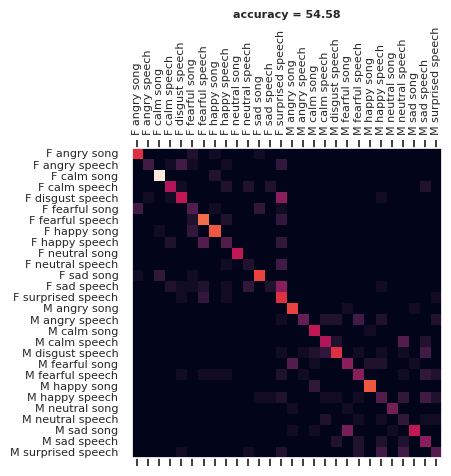

In [10]:
from sklearn.metrics import confusion_matrix

plt.matshow(confusion_matrix(y[test_idxs], ypred))
plt.xticks(np.unique(y), labels = enc.inverse_transform(np.unique(y)), rotation=90);
plt.yticks(np.unique(y), labels = enc.inverse_transform(np.unique(y)), rotation=0);

plt.title(f"accuracy = {accuracy_score(y[test_idxs], ypred)*100:.2f}")
plt.minorticks_off()
plt.grid(ls="")

## Tuning (for prediction of emotion only)

### Get labels

In [4]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
labels = df.actor.to_numpy()
y = enc.fit_transform(labels)

### Split dataset

In [5]:
idxs = np.arange(len(df))
np.random.shuffle(idxs)
train_idxs, val_idxs, test_idxs = np.split(idxs, (len(df)*np.array([0.7, 0.8])).astype(int))

### Belly network

In [9]:
X = STFT_dict[90]

belly_params = dict(conv_filter_sizes=[20, 15, 5 ], conv_kernel_sizes=[5,7, 4], conv_pool_sizes=[3,5, 7],
                    conv_padding="valid",
                   n_dense_layers=3, dense_nodes=256, 
                    batch_size=25, epochs=30,)
cnn = build_model(X.shape[1:], len(np.unique(y)), **belly_params)
cnn.summary()

# Train on train+validation
final_train_idxs = np.concatenate((train_idxs, val_idxs))

cnn.fit(X[final_train_idxs], 
        y[final_train_idxs], 
        epochs=belly_params["epochs"], 
        batch_size=belly_params["batch_size"], validation_split=0.15)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_0 (Conv1D)             (None, 333, 20)           9020      
                                                                 
 avg_pooling_0 (AveragePooli  (None, 111, 20)          0         
 ng1D)                                                           
                                                                 
 conv_1 (Conv1D)             (None, 105, 15)           2115      
                                                                 
 avg_pooling_1 (AveragePooli  (None, 21, 15)           0         
 ng1D)                                                           
                                                                 
 conv_2 (Conv1D)             (None, 18, 5)             305       
                                                                 
 flatten_2 (Flatten)         (None, 90)               

In [10]:
from sklearn.metrics import accuracy_score

ypred = np.argmax(cnn.predict(X[test_idxs]), axis=1)

print(accuracy_score(y[test_idxs], ypred))

16/16 [==============================] - 0s 13ms/step
0.4684317718940937


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


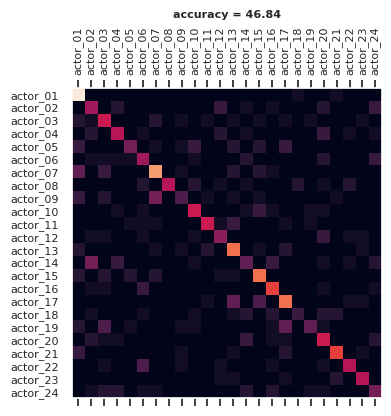

In [11]:
from sklearn.metrics import confusion_matrix

plt.matshow(confusion_matrix(y[test_idxs], ypred))
plt.xticks(np.unique(y), labels = enc.inverse_transform(np.unique(y)), rotation=90);
plt.yticks(np.unique(y), labels = enc.inverse_transform(np.unique(y)), rotation=0);

plt.title(f"accuracy = {accuracy_score(y[test_idxs], ypred)*100:.2f}")
plt.minorticks_off()
plt.grid(ls="")

### Start the study

In [ ]:
import optuna
study = optuna.create_study(direction='maximize')
trial_function = lambda trial: objective(trial, train_idxs, val_idxs)
study.optimize(trial_function, n_trials=300, n_jobs=1, catch=ValueError)

[I 2023-07-03 20:49:43,922] A new study created in memory with name: no-name-713dfdcc-2a3e-4220-84a1-8e05a5ff08ec


running model having {'conv_filter_sizes': [11], 'conv_kernel_sizes': [4], 'conv_pool_sizes': [4], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 504} with SpRes = 115 for epochs = 16


[I 2023-07-03 20:50:29,643] Trial 0 finished with value: 0.17142857142857143 and parameters: {'epochs': 16, 'resolution': 100, 'n_conv_blocks': 1, 'filters_0': 11, 'kernels_0': 4, 'pool_0': 4, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 504, 'batch_size': 21}. Best is trial 0 with value: 0.17142857142857143.


running model having {'conv_filter_sizes': [6, 11, 8], 'conv_kernel_sizes': [6, 5, 8], 'conv_pool_sizes': [3, 2, 2], 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 312} with SpRes = 115 for epochs = 26


[I 2023-07-03 20:51:09,601] Trial 1 finished with value: 0.2571428571428571 and parameters: {'epochs': 26, 'resolution': 115, 'n_conv_blocks': 3, 'filters_0': 6, 'kernels_0': 6, 'pool_0': 3, 'filters_1': 11, 'kernels_1': 5, 'pool_1': 2, 'filters_2': 8, 'kernels_2': 8, 'pool_2': 2, 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 312, 'batch_size': 17}. Best is trial 1 with value: 0.2571428571428571.


running model having {'conv_filter_sizes': [3], 'conv_kernel_sizes': [5], 'conv_pool_sizes': [3], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 286} with SpRes = 115 for epochs = 40


[I 2023-07-03 20:52:05,999] Trial 2 finished with value: 0.18775510204081633 and parameters: {'epochs': 40, 'resolution': 115, 'n_conv_blocks': 1, 'filters_0': 3, 'kernels_0': 5, 'pool_0': 3, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 286, 'batch_size': 21}. Best is trial 1 with value: 0.2571428571428571.


running model having {'conv_filter_sizes': [14], 'conv_kernel_sizes': [5], 'conv_pool_sizes': [8], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 80} with SpRes = 115 for epochs = 33


[I 2023-07-03 20:52:55,036] Trial 3 finished with value: 0.24081632653061225 and parameters: {'epochs': 33, 'resolution': 115, 'n_conv_blocks': 1, 'filters_0': 14, 'kernels_0': 5, 'pool_0': 8, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 80, 'batch_size': 20}. Best is trial 1 with value: 0.2571428571428571.


running model having {'conv_filter_sizes': [15], 'conv_kernel_sizes': [7], 'conv_pool_sizes': [6], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 65} with SpRes = 115 for epochs = 28


[I 2023-07-03 20:53:39,651] Trial 4 finished with value: 0.24489795918367346 and parameters: {'epochs': 28, 'resolution': 115, 'n_conv_blocks': 1, 'filters_0': 15, 'kernels_0': 7, 'pool_0': 6, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 65, 'batch_size': 30}. Best is trial 1 with value: 0.2571428571428571.


running model having {'conv_filter_sizes': [11, 13], 'conv_kernel_sizes': [9, 5], 'conv_pool_sizes': [8, 5], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 24} with SpRes = 115 for epochs = 37


[I 2023-07-03 20:54:46,693] Trial 5 finished with value: 0.40816326530612246 and parameters: {'epochs': 37, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 11, 'kernels_0': 9, 'pool_0': 8, 'filters_1': 13, 'kernels_1': 5, 'pool_1': 5, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 24, 'batch_size': 17}. Best is trial 5 with value: 0.40816326530612246.


running model having {'conv_filter_sizes': [9, 6], 'conv_kernel_sizes': [6, 3], 'conv_pool_sizes': [7, 6], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 440} with SpRes = 115 for epochs = 16


[I 2023-07-03 20:55:15,446] Trial 6 finished with value: 0.3510204081632653 and parameters: {'epochs': 16, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 9, 'kernels_0': 6, 'pool_0': 7, 'filters_1': 6, 'kernels_1': 3, 'pool_1': 6, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 440, 'batch_size': 20}. Best is trial 5 with value: 0.40816326530612246.


running model having {'conv_filter_sizes': [15], 'conv_kernel_sizes': [6], 'conv_pool_sizes': [8], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 145} with SpRes = 115 for epochs = 34


[I 2023-07-03 20:56:13,929] Trial 7 finished with value: 0.2 and parameters: {'epochs': 34, 'resolution': 90, 'n_conv_blocks': 1, 'filters_0': 15, 'kernels_0': 6, 'pool_0': 8, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 145, 'batch_size': 32}. Best is trial 5 with value: 0.40816326530612246.


running model having {'conv_filter_sizes': [10, 13, 12], 'conv_kernel_sizes': [7, 8, 4], 'conv_pool_sizes': [5, 7, 4], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 55} with SpRes = 115 for epochs = 40


[I 2023-07-03 20:57:20,383] Trial 8 finished with value: 0.39183673469387753 and parameters: {'epochs': 40, 'resolution': 100, 'n_conv_blocks': 3, 'filters_0': 10, 'kernels_0': 7, 'pool_0': 5, 'filters_1': 13, 'kernels_1': 8, 'pool_1': 7, 'filters_2': 12, 'kernels_2': 4, 'pool_2': 4, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 55, 'batch_size': 24}. Best is trial 5 with value: 0.40816326530612246.


running model having {'conv_filter_sizes': [16, 6], 'conv_kernel_sizes': [9, 4], 'conv_pool_sizes': [7, 3], 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 161} with SpRes = 115 for epochs = 26


[I 2023-07-03 20:58:07,320] Trial 9 finished with value: 0.3673469387755102 and parameters: {'epochs': 26, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 9, 'pool_0': 7, 'filters_1': 6, 'kernels_1': 4, 'pool_1': 3, 'conv_padding': 'causal', 'n_dense_layers': 3, 'dense_nodes': 161, 'batch_size': 31}. Best is trial 5 with value: 0.40816326530612246.


running model having {'conv_filter_sizes': [7, 16], 'conv_kernel_sizes': [9, 7], 'conv_pool_sizes': [2, 4], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 203} with SpRes = 115 for epochs = 34


[I 2023-07-03 20:59:31,214] Trial 10 finished with value: 0.2163265306122449 and parameters: {'epochs': 34, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 7, 'kernels_0': 9, 'pool_0': 2, 'filters_1': 16, 'kernels_1': 7, 'pool_1': 4, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 203, 'batch_size': 16}. Best is trial 5 with value: 0.40816326530612246.


running model having {'conv_filter_sizes': [11, 13, 16], 'conv_kernel_sizes': [8, 9, 3], 'conv_pool_sizes': [5, 8, 6], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 23} with SpRes = 115 for epochs = 40


[I 2023-07-03 21:00:37,513] Trial 11 finished with value: 0.45714285714285713 and parameters: {'epochs': 40, 'resolution': 100, 'n_conv_blocks': 3, 'filters_0': 11, 'kernels_0': 8, 'pool_0': 5, 'filters_1': 13, 'kernels_1': 9, 'pool_1': 8, 'filters_2': 16, 'kernels_2': 3, 'pool_2': 6, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 23, 'batch_size': 27}. Best is trial 11 with value: 0.45714285714285713.


running model having {'conv_filter_sizes': [12, 14, 16], 'conv_kernel_sizes': [8, 9, 3], 'conv_pool_sizes': [5, 8, 8], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 16} with SpRes = 115 for epochs = 36


[I 2023-07-03 21:01:39,414] Trial 12 finished with value: 0.46530612244897956 and parameters: {'epochs': 36, 'resolution': 100, 'n_conv_blocks': 3, 'filters_0': 12, 'kernels_0': 8, 'pool_0': 5, 'filters_1': 14, 'kernels_1': 9, 'pool_1': 8, 'filters_2': 16, 'kernels_2': 3, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 16, 'batch_size': 27}. Best is trial 12 with value: 0.46530612244897956.


running model having {'conv_filter_sizes': [13, 16, 16], 'conv_kernel_sizes': [8, 9, 3], 'conv_pool_sizes': [5, 8, 8], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 127} with SpRes = 115 for epochs = 29


[I 2023-07-03 21:02:28,856] Trial 13 finished with value: 0.45714285714285713 and parameters: {'epochs': 29, 'resolution': 100, 'n_conv_blocks': 3, 'filters_0': 13, 'kernels_0': 8, 'pool_0': 5, 'filters_1': 16, 'kernels_1': 9, 'pool_1': 8, 'filters_2': 16, 'kernels_2': 3, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 127, 'batch_size': 28}. Best is trial 12 with value: 0.46530612244897956.


running model having {'conv_filter_sizes': [12, 10, 16], 'conv_kernel_sizes': [8, 9, 3], 'conv_pool_sizes': [4, 8, 8], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 16} with SpRes = 115 for epochs = 37


[I 2023-07-03 21:03:32,577] Trial 14 finished with value: 0.4326530612244898 and parameters: {'epochs': 37, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 12, 'kernels_0': 8, 'pool_0': 4, 'filters_1': 10, 'kernels_1': 9, 'pool_1': 8, 'filters_2': 16, 'kernels_2': 3, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 16, 'batch_size': 27}. Best is trial 12 with value: 0.46530612244897956.


running model having {'conv_filter_sizes': [8, 13, 2], 'conv_kernel_sizes': [8, 7, 6], 'conv_pool_sizes': [6, 7, 6], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 221} with SpRes = 115 for epochs = 22


[I 2023-07-03 21:04:10,570] Trial 15 finished with value: 0.2163265306122449 and parameters: {'epochs': 22, 'resolution': 100, 'n_conv_blocks': 3, 'filters_0': 8, 'kernels_0': 8, 'pool_0': 6, 'filters_1': 13, 'kernels_1': 7, 'pool_1': 7, 'filters_2': 2, 'kernels_2': 6, 'pool_2': 6, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 221, 'batch_size': 25}. Best is trial 12 with value: 0.46530612244897956.


running model having {'conv_filter_sizes': [5, 2, 12], 'conv_kernel_sizes': [3, 9, 5], 'conv_pool_sizes': [4, 8, 6], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 348} with SpRes = 115 for epochs = 31


[I 2023-07-03 21:04:43,162] Trial 16 finished with value: 0.4204081632653061 and parameters: {'epochs': 31, 'resolution': 100, 'n_conv_blocks': 3, 'filters_0': 5, 'kernels_0': 3, 'pool_0': 4, 'filters_1': 2, 'kernels_1': 9, 'pool_1': 8, 'filters_2': 12, 'kernels_2': 5, 'pool_2': 6, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 348, 'batch_size': 28}. Best is trial 12 with value: 0.46530612244897956.


running model having {'conv_filter_sizes': [12, 14, 13], 'conv_kernel_sizes': [7, 7, 3], 'conv_pool_sizes': [6, 6, 7], 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 120} with SpRes = 115 for epochs = 37


[I 2023-07-03 21:05:41,545] Trial 17 finished with value: 0.4448979591836735 and parameters: {'epochs': 37, 'resolution': 100, 'n_conv_blocks': 3, 'filters_0': 12, 'kernels_0': 7, 'pool_0': 6, 'filters_1': 14, 'kernels_1': 7, 'pool_1': 6, 'filters_2': 13, 'kernels_2': 3, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 120, 'batch_size': 25}. Best is trial 12 with value: 0.46530612244897956.


running model having {'conv_filter_sizes': [9, 8], 'conv_kernel_sizes': [8, 8], 'conv_pool_sizes': [5, 7], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 211} with SpRes = 115 for epochs = 22


[I 2023-07-03 21:06:19,658] Trial 18 finished with value: 0.4163265306122449 and parameters: {'epochs': 22, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 9, 'kernels_0': 8, 'pool_0': 5, 'filters_1': 8, 'kernels_1': 8, 'pool_1': 7, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 211, 'batch_size': 29}. Best is trial 12 with value: 0.46530612244897956.


running model having {'conv_filter_sizes': [2, 11, 7], 'conv_kernel_sizes': [7, 8, 9], 'conv_pool_sizes': [3, 6, 4], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 396} with SpRes = 115 for epochs = 40


[I 2023-07-03 21:07:23,075] Trial 19 finished with value: 0.42857142857142855 and parameters: {'epochs': 40, 'resolution': 90, 'n_conv_blocks': 3, 'filters_0': 2, 'kernels_0': 7, 'pool_0': 3, 'filters_1': 11, 'kernels_1': 8, 'pool_1': 6, 'filters_2': 7, 'kernels_2': 9, 'pool_2': 4, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 396, 'batch_size': 23}. Best is trial 12 with value: 0.46530612244897956.


running model having {'conv_filter_sizes': [13, 15, 16], 'conv_kernel_sizes': [9, 6, 5], 'conv_pool_sizes': [5, 5, 6], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 89} with SpRes = 115 for epochs = 37


[I 2023-07-03 21:08:32,748] Trial 20 finished with value: 0.3836734693877551 and parameters: {'epochs': 37, 'resolution': 100, 'n_conv_blocks': 3, 'filters_0': 13, 'kernels_0': 9, 'pool_0': 5, 'filters_1': 15, 'kernels_1': 6, 'pool_1': 5, 'filters_2': 16, 'kernels_2': 5, 'pool_2': 6, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 89, 'batch_size': 26}. Best is trial 12 with value: 0.46530612244897956.


running model having {'conv_filter_sizes': [13, 15, 16], 'conv_kernel_sizes': [8, 9, 3], 'conv_pool_sizes': [5, 8, 8], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 118} with SpRes = 115 for epochs = 30


[I 2023-07-03 21:09:25,186] Trial 21 finished with value: 0.45714285714285713 and parameters: {'epochs': 30, 'resolution': 100, 'n_conv_blocks': 3, 'filters_0': 13, 'kernels_0': 8, 'pool_0': 5, 'filters_1': 15, 'kernels_1': 9, 'pool_1': 8, 'filters_2': 16, 'kernels_2': 3, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 118, 'batch_size': 28}. Best is trial 12 with value: 0.46530612244897956.


running model having {'conv_filter_sizes': [11, 16, 14], 'conv_kernel_sizes': [8, 9, 4], 'conv_pool_sizes': [6, 8, 8], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 23} with SpRes = 115 for epochs = 23


[I 2023-07-03 21:10:05,145] Trial 22 finished with value: 0.40408163265306124 and parameters: {'epochs': 23, 'resolution': 100, 'n_conv_blocks': 3, 'filters_0': 11, 'kernels_0': 8, 'pool_0': 6, 'filters_1': 16, 'kernels_1': 9, 'pool_1': 8, 'filters_2': 14, 'kernels_2': 4, 'pool_2': 8, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 23, 'batch_size': 27}. Best is trial 12 with value: 0.46530612244897956.


running model having {'conv_filter_sizes': [13, 12, 14], 'conv_kernel_sizes': [8, 8, 4], 'conv_pool_sizes': [4, 7, 7], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 163} with SpRes = 115 for epochs = 35


[I 2023-07-03 21:11:05,510] Trial 23 finished with value: 0.42857142857142855 and parameters: {'epochs': 35, 'resolution': 100, 'n_conv_blocks': 3, 'filters_0': 13, 'kernels_0': 8, 'pool_0': 4, 'filters_1': 12, 'kernels_1': 8, 'pool_1': 7, 'filters_2': 14, 'kernels_2': 4, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 163, 'batch_size': 30}. Best is trial 12 with value: 0.46530612244897956.


running model having {'conv_filter_sizes': [10, 16], 'conv_kernel_sizes': [7, 9], 'conv_pool_sizes': [7, 8], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 95} with SpRes = 115 for epochs = 31


[I 2023-07-03 21:11:56,169] Trial 24 finished with value: 0.43673469387755104 and parameters: {'epochs': 31, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 10, 'kernels_0': 7, 'pool_0': 7, 'filters_1': 16, 'kernels_1': 9, 'pool_1': 8, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 95, 'batch_size': 23}. Best is trial 12 with value: 0.46530612244897956.


running model having {'conv_filter_sizes': [14, 14, 10], 'conv_kernel_sizes': [9, 8, 3], 'conv_pool_sizes': [5, 7, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 44} with SpRes = 115 for epochs = 38


[I 2023-07-03 21:13:04,088] Trial 25 finished with value: 0.42857142857142855 and parameters: {'epochs': 38, 'resolution': 100, 'n_conv_blocks': 3, 'filters_0': 14, 'kernels_0': 9, 'pool_0': 5, 'filters_1': 14, 'kernels_1': 8, 'pool_1': 7, 'filters_2': 10, 'kernels_2': 3, 'pool_2': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 44, 'batch_size': 29}. Best is trial 12 with value: 0.46530612244897956.


running model having {'conv_filter_sizes': [12, 14], 'conv_kernel_sizes': [8, 9], 'conv_pool_sizes': [4, 8], 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 126} with SpRes = 115 for epochs = 19


[I 2023-07-03 21:13:39,002] Trial 26 finished with value: 0.42448979591836733 and parameters: {'epochs': 19, 'resolution': 100, 'n_conv_blocks': 2, 'filters_0': 12, 'kernels_0': 8, 'pool_0': 4, 'filters_1': 14, 'kernels_1': 9, 'pool_1': 8, 'conv_padding': 'valid', 'n_dense_layers': 3, 'dense_nodes': 126, 'batch_size': 26}. Best is trial 12 with value: 0.46530612244897956.


running model having {'conv_filter_sizes': [16, 9, 16], 'conv_kernel_sizes': [6, 7, 4], 'conv_pool_sizes': [6, 7, 5], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 248} with SpRes = 115 for epochs = 29


[I 2023-07-03 21:14:20,035] Trial 27 finished with value: 0.5061224489795918 and parameters: {'epochs': 29, 'resolution': 110, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 6, 'pool_0': 6, 'filters_1': 9, 'kernels_1': 7, 'pool_1': 7, 'filters_2': 16, 'kernels_2': 4, 'pool_2': 5, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 248, 'batch_size': 27}. Best is trial 27 with value: 0.5061224489795918.


running model having {'conv_filter_sizes': [16, 8, 5], 'conv_kernel_sizes': [5, 6, 5], 'conv_pool_sizes': [6, 6, 4], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 245} with SpRes = 115 for epochs = 33


[I 2023-07-03 21:15:00,629] Trial 28 finished with value: 0.4122448979591837 and parameters: {'epochs': 33, 'resolution': 110, 'n_conv_blocks': 3, 'filters_0': 16, 'kernels_0': 5, 'pool_0': 6, 'filters_1': 8, 'kernels_1': 6, 'pool_1': 6, 'filters_2': 5, 'kernels_2': 5, 'pool_2': 4, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 245, 'batch_size': 26}. Best is trial 27 with value: 0.5061224489795918.


running model having {'conv_filter_sizes': [15, 9], 'conv_kernel_sizes': [4, 7], 'conv_pool_sizes': [7, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 503} with SpRes = 115 for epochs = 26


[I 2023-07-03 21:15:35,689] Trial 29 finished with value: 0.46122448979591835 and parameters: {'epochs': 26, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 4, 'pool_0': 7, 'filters_1': 9, 'kernels_1': 7, 'pool_1': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 503, 'batch_size': 24}. Best is trial 27 with value: 0.5061224489795918.


running model having {'conv_filter_sizes': [15, 9], 'conv_kernel_sizes': [3, 7], 'conv_pool_sizes': [7, 5], 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 492} with SpRes = 115 for epochs = 25


[I 2023-07-03 21:16:02,474] Trial 30 finished with value: 0.42857142857142855 and parameters: {'epochs': 25, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 7, 'filters_1': 9, 'kernels_1': 7, 'pool_1': 5, 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 492, 'batch_size': 22}. Best is trial 27 with value: 0.5061224489795918.


running model having {'conv_filter_sizes': [16, 7], 'conv_kernel_sizes': [4, 7], 'conv_pool_sizes': [6, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 509} with SpRes = 115 for epochs = 24


[I 2023-07-03 21:16:34,378] Trial 31 finished with value: 0.4 and parameters: {'epochs': 24, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 4, 'pool_0': 6, 'filters_1': 7, 'kernels_1': 7, 'pool_1': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 509, 'batch_size': 24}. Best is trial 27 with value: 0.5061224489795918.


running model having {'conv_filter_sizes': [14, 10], 'conv_kernel_sizes': [4, 6], 'conv_pool_sizes': [7, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 361} with SpRes = 115 for epochs = 20


[I 2023-07-03 21:16:58,700] Trial 32 finished with value: 0.5102040816326531 and parameters: {'epochs': 20, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 4, 'pool_0': 7, 'filters_1': 10, 'kernels_1': 6, 'pool_1': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 361, 'batch_size': 27}. Best is trial 32 with value: 0.5102040816326531.


running model having {'conv_filter_sizes': [14, 10], 'conv_kernel_sizes': [4, 5], 'conv_pool_sizes': [7, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 342} with SpRes = 115 for epochs = 19


[I 2023-07-03 21:17:22,290] Trial 33 finished with value: 0.2979591836734694 and parameters: {'epochs': 19, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 14, 'kernels_0': 4, 'pool_0': 7, 'filters_1': 10, 'kernels_1': 5, 'pool_1': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 342, 'batch_size': 25}. Best is trial 32 with value: 0.5102040816326531.


running model having {'conv_filter_sizes': [15, 4], 'conv_kernel_sizes': [4, 6], 'conv_pool_sizes': [7, 6], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 442} with SpRes = 115 for epochs = 20


[I 2023-07-03 21:17:47,381] Trial 34 finished with value: 0.33877551020408164 and parameters: {'epochs': 20, 'resolution': 110, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 4, 'pool_0': 7, 'filters_1': 4, 'kernels_1': 6, 'pool_1': 6, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 442, 'batch_size': 24}. Best is trial 32 with value: 0.5102040816326531.


running model having {'conv_filter_sizes': [14], 'conv_kernel_sizes': [5], 'conv_pool_sizes': [8], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 294} with SpRes = 115 for epochs = 15


[I 2023-07-03 21:18:17,825] Trial 35 finished with value: 0.20408163265306123 and parameters: {'epochs': 15, 'resolution': 110, 'n_conv_blocks': 1, 'filters_0': 14, 'kernels_0': 5, 'pool_0': 8, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 294, 'batch_size': 29}. Best is trial 32 with value: 0.5102040816326531.


running model having {'conv_filter_sizes': [16, 11], 'conv_kernel_sizes': [3, 6], 'conv_pool_sizes': [6, 7], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 380} with SpRes = 115 for epochs = 26


[I 2023-07-03 21:18:48,503] Trial 36 finished with value: 0.5102040816326531 and parameters: {'epochs': 26, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 11, 'kernels_1': 6, 'pool_1': 7, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 380, 'batch_size': 22}. Best is trial 32 with value: 0.5102040816326531.


running model having {'conv_filter_sizes': [16, 11], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 6], 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 376} with SpRes = 115 for epochs = 28


[I 2023-07-03 21:19:22,111] Trial 37 finished with value: 0.46938775510204084 and parameters: {'epochs': 28, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 11, 'kernels_1': 5, 'pool_1': 6, 'conv_padding': 'valid', 'n_dense_layers': 2, 'dense_nodes': 376, 'batch_size': 22}. Best is trial 32 with value: 0.5102040816326531.


running model having {'conv_filter_sizes': [16], 'conv_kernel_sizes': [3], 'conv_pool_sizes': [6], 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 384} with SpRes = 115 for epochs = 28


[I 2023-07-03 21:20:32,199] Trial 38 finished with value: 0.17142857142857143 and parameters: {'epochs': 28, 'resolution': 115, 'n_conv_blocks': 1, 'filters_0': 16, 'kernels_0': 3, 'pool_0': 6, 'conv_padding': 'causal', 'n_dense_layers': 2, 'dense_nodes': 384, 'batch_size': 19}. Best is trial 32 with value: 0.5102040816326531.


running model having {'conv_filter_sizes': [16, 11], 'conv_kernel_sizes': [3, 5], 'conv_pool_sizes': [6, 2], 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 325} with SpRes = 115 for epochs = 28


[I 2023-07-03 21:21:02,480] Trial 39 finished with value: 0.44081632653061226 and parameters: {'epochs': 28, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 16, 'kernels_0': 3, 'pool_0': 6, 'filters_1': 11, 'kernels_1': 5, 'pool_1': 2, 'conv_padding': 'valid', 'n_dense_layers': 1, 'dense_nodes': 325, 'batch_size': 20}. Best is trial 32 with value: 0.5102040816326531.


running model having {'conv_filter_sizes': [15, 11], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [8, 6], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 385} with SpRes = 115 for epochs = 17


[I 2023-07-03 21:21:21,949] Trial 40 finished with value: 0.5102040816326531 and parameters: {'epochs': 17, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 8, 'filters_1': 11, 'kernels_1': 4, 'pool_1': 6, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 385, 'batch_size': 21}. Best is trial 32 with value: 0.5102040816326531.


running model having {'conv_filter_sizes': [15, 11], 'conv_kernel_sizes': [3, 4], 'conv_pool_sizes': [8, 6], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 383} with SpRes = 115 for epochs = 18


[I 2023-07-03 21:21:42,374] Trial 41 finished with value: 0.5673469387755102 and parameters: {'epochs': 18, 'resolution': 115, 'n_conv_blocks': 2, 'filters_0': 15, 'kernels_0': 3, 'pool_0': 8, 'filters_1': 11, 'kernels_1': 4, 'pool_1': 6, 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 383, 'batch_size': 21}. Best is trial 41 with value: 0.5673469387755102.


running model having {'conv_filter_sizes': [15, 10], 'conv_kernel_sizes': [3, 3], 'conv_pool_sizes': [8, 5], 'conv_padding': 'causal', 'n_dense_layers': 1, 'dense_nodes': 413} with SpRes = 115 for epochs = 17


## Results

In [ ]:
best_params_emotion = study.best_params.copy()

# Retrieves best parameters form the dict and saves them as a list
best_params_emotion["conv_filter_sizes"] = []
best_params_emotion["conv_kernel_sizes"] = []
best_params_emotion["conv_pool_sizes"] = []

for key in np.sort(list(study.best_params.keys())):
    if "filter" in key:
        best_params_emotion["conv_filter_sizes"].append(study.best_params[key])
    if "kernel" in key:
        best_params_emotion["conv_kernel_sizes"].append(study.best_params[key])
    if "pool" in key:
        best_params_emotion["conv_pool_sizes"].append(study.best_params[key])

print("for all-class best is", best_params_emotion)
        
        
        
X = STFT_dict[best_params_emotion["resolution"]]

cnn = build_model(X.shape[1:], len(np.unique(y)), **best_params_emotion)
cnn.summary()

# Train on train+validation
final_train_idxs = np.concatenate((train_idxs, val_idxs))

cnn.fit(X[final_train_idxs], 
        y[final_train_idxs], 
        epochs=best_params_emotion["epochs"], 
        batch_size=best_params_emotion["batch_size"])

In [ ]:
from sklearn.metrics import accuracy_score

ypred = np.argmax(cnn.predict(X[test_idxs]), axis=1)

print(accuracy_score(y[test_idxs], ypred))

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

fig, ax = plt.subplots(1,1,figsize=default_style.HALFSIZE_FIGURE)

im = ax.matshow(confusion_matrix(y[test_idxs], ypred))
ax.set_xticks(np.unique(y), labels = enc.inverse_transform(np.unique(y)), rotation=90);
ax.set_yticks(np.unique(y), labels = enc.inverse_transform(np.unique(y)), rotation=0);

ax.set_title(f"accuracy = {accuracy_score(y[test_idxs], ypred)*100:.2f}")
ax.grid(ls="")
ax.minorticks_off()
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
fig.tight_layout()
fig.savefig("../images/ts_emotion_classification.pdf")
print(classification_report(enc.inverse_transform(y[test_idxs]), enc.inverse_transform(ypred)))

## Print filters

In [ ]:
for layer in cnn.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)


In [ ]:
filters, biases = cnn.get_layer("conv_0").get_weights()

n_filters = filters.shape[-1]
fig, axes = plt.subplots(n_filters, 1, 
                         sharex=True, 
                         figsize=(10, 5), 
                         constrained_layout=True)
for i in range(n_filters):
    axes[i].axis("off")
    axes[i].matshow(filters[:,:,i])
